<a href="https://colab.research.google.com/github/FabrizioCabreraC/Hollywood-as-recession-proof/blob/main/Hollywood_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#%pip install cpi
%matplotlib inline
#%pip install scrapy
#import scrapy
#%pip install statsmodels
import statsmodels.api as sm
from statsmodels.api import OLS
import requests
%pip install fredapi
from fredapi import Fred #package for pulling from FRED API
import matplotlib
import matplotlib.transforms as transforms

Note: you may need to restart the kernel to use updated packages.


# Background

Every time the economy dips, trade papers and the general interest press start to speculate about the dip's effects on entertainment and the film industry. [Commentators](https://www.hollywoodreporter.com/news/general-news/how-recession-proof-is-hollywood-now-1169172/) in the business section usually seem to be optimistic about the industry pointing to an increased need for distraction in times of hardship, whereas commentators from the culture sector seem to be pessimistic, especially concerning funding for highbrow entertainment. This creates an interesting insight into the demand versus supplu of moives during a pandemic. However, to our knowledge, neither side has presented sound data to support its rerasoning as both seem rely on anecdotal evidence. Turning towards the academic literature is not satisfactory either, since the rather few studies conducted provide no clear answer. Instead they raise the question of whether the economy is an important influencing factor at all. Therefore, we believe that this is a relevant topic for study as a better understanding of the influence of economic growth on the size and nature of the demand and supply for cinema entertainment can ultimately lead to a betteer alloaction of production resources.

# Literature Review

The literature review of cinema supply and demand suggests that economic downturns could either lead to a sober mood and drive the interest in serious genres, or increase the need for distraction leading to a drive to see more feel-good movies (Pettijohn and Sacco 2009). However, characteristics of the movie industry suggest that key economic factors have only limited effects on supply and demand (Langford 2004). Evidence of supply and demand in three major European markets indicate that demand is unrelated to the state of the economy. In aggregate accordding to (Peterson and Anand 2004: 317-8), the demand does not instruct supply. 

# Objectives

This project tries to addresses whether the state of the economy impacts the supply of and demand for cinema entertainment through three questions: 

1.   To what extent can the state of the economy explain demand for cinema entertainment?  

2.   To what extent can the economy explain the supply of movies?  

3.   Does the state of the economy influence the supply of specific genres?

Note: As the popularity of streaming sevices exploded in the mid 2010s and Covid-19 has permenately changed the business model for releasing films, this porject will focus on seeing if Hollywood USE to be recession proof as claimed. It will not attempt to explain contempory trends as a differnt project stucture and datasets would be required. 

# Hypothesis

# Datasets

To try and answer the question of how recession-proof the film industry is we collected data from three different sources.

1. Economic data was pulled from the Federal Reserve Economic Database through the use of the FRED API. More specifically the fredapi package was used with a custom-built function to pull individual series. This data includes real GDP, PCE, Unemployment Rate, Consumer Confidence, real GDP per capita, and average gas prices. The time series collected for these indicators varies but was restructured to show yearly data to more easily interpret the visual charts. All the variables were merged to start in 1982, as this matches the years available for box office data.

2. Annual Box office data was pulled from the yearly domestic box office table on the website BoxOffice Mojo through read.html. This data contains the total U.S. box office revenue for films released that year as well as the and total films released in theaters. This data was then merged with the economic data table. As data seemed inconsistent before 1982, data was only taken from 1982-2020.

3. Movie genre and ratings data were taken from links via read.html to the IMDB database. More specifically the title.basics.tsv.gz and the title.ratings.tsv.gz tables from within the database. These two tables were merged to provide the total genres produced and yearly average review scores for all movies released. This is not specific to just movies released in theaters and includes any movies put onto IMDB including straight to video and streaming-only releases.

# Outline
Section 1: The Data
1.   Cleanging the FRED API Data
2.   Cleaning the Box Office Mojo Data
3.   Cleaning IMDB data and creating genre super categories

Section 2: Visualizations
1.   Examination and summary of the economic variables and U.S. recessions
2.   Examination of the demand for movies: Gross revenues compared to the economic indicators
3.   Examination of the supply for movies: Number of releases and genres compared to the economic indicators

Section 3: Interpriation and Conculsion
1.   Interpretation: answering our research questions
2.   Conclusion: discussion of limitations, areas for further research

# Section 1: The Data
Obtaining the desired datasets from FRED API, Box Office Mojo, and IMDB

### 1.1 Fred API:

Pulling economic data series from the FRED API using the fredapi package for simplification.

In [2]:
def get_fred (series_code: str):
    '''
    Pulls data from FRED API in the form of an indiviudal series and returns cleaned 
    data set
    
    parameter
    --------
    sereies_code: Code for specific data series taken from the FRED website 
    
    returns:
    --------
    cleaned: a dataframe of the FRED series cleaned to contain the 
            date of the data in the index
    '''
    fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da") # my API Key,
    
    data = fred.get_series(f"{series_code}")
    dataframe = pd.DataFrame(data)
    data_rn = {0 : f"{series_code}"} #renames value columns given lable of 0 in some cases
    cleaned = dataframe.rename(data_rn, axis=1)
    cleaned = cleaned.reset_index()
    a = {"index": "Date"}
    cleaned = cleaned.rename(a, axis = 1)
    cleaned["Date"] = pd.to_datetime(cleaned["Date"])
    return cleaned

In [3]:
unemp = get_fred("UNRATE") # unemplyment rate, by month
#unemp

GDP = get_fred("GDPC1") #nominal, by quater, real gdp
#GDP

consumer_sent = get_fred("UMCSENT") # U Mich consumer sentiment, by month
#consumer_sent

debt_income = get_fred("TDSP") #total debt service to income ratio, by quater, not used
#debt_income

gdp_capita = get_fred("A939RX0Q048SBEA") #real ratio, by quater 
#gdp_capita

gas_prices = get_fred("GASREGCOVW") #national gas price average, by week, not used
#gas_prices

inflation = get_fred("FPCPITOTLZGUSA") #inflation rate, by year, not used
#inflation

PCE = get_fred("DPCERD3Q086SBEA") #PCE with index set to 2012, quarterly
#PCE

Renaming the series to be more user friendly.

In [4]:
j = {"GDPC1" : "GDP"}
GDP = GDP.rename(j, axis=1)
#GDP

p = {"DPCERD3Q086SBEA": "PCE"}
PCE = PCE.rename(p, axis =1 )
#PCE

i = {"FPCPITOTLZGUSA" : "inflat_index"}
inflation = inflation.rename(i, axis=1)
#inflation

Consum_Sent = {"UMCSENT" : "consum_sent"}
consumer_sent = consumer_sent.rename(Consum_Sent, axis=1)
#consumer_sent

gas = {"GASREGCOVW" : "gas_price"}
gas_prices = gas_prices.rename(gas, axis=1)
gas_prices = (gas_prices.set_index("Date").
              resample("MS").mean().
              reset_index())
#gas_prices

jeff = {"A939RX0Q048SBEA" : "gdp_per_capita"}
gdp_capita = gdp_capita.rename(jeff, axis=1)
#GDP_per_capita

debt_pct_income = {"TDSP" : "debt_pct_income"}
debt_income = debt_income.rename(debt_pct_income, axis=1)
#Debt_Payment

In [5]:
data_month = unemp.merge(consumer_sent.merge(gas_prices, on="Date", how="outer"))
#data_month.head(10)

data_qrt = data_month.set_index("Date").resample("QS").mean().reset_index()
#data_qrt.head(10)

data_qrt = data_qrt.merge(
    GDP.merge(
    gdp_capita.merge(
    PCE.merge(
    debt_income, on="Date", how = "outer"))))
#data_qrt.head()

data_year = data_qrt.set_index("Date").resample("YS").mean()

### 1.2 Box Office Mojo: 

As data was avaible from 1977 but didn't appear to be reliable until 1982, data was only used from 1982 to 2020.

In [6]:
def get_table(url):
    '''
    Function recovers the datatable requested from the boxoffice mojo
    url and outputs to a dataframe.

    parameter
    ---------
    url: url of the box office mojo page containing the desired table.

    returns
    -------
    table_df: the dataframe from the table on the specific box office mojo page
    '''
    response = requests.get(url).content
    table = pd.read_html(response)
    table_df = pd.DataFrame(table[-1])
    return table_df

In [7]:
url = "https://www.boxofficemojo.com/year/?ref_=bo_nb_ml_secondarytab"
box_year = get_table(url)

In [8]:
# quaretly data pulled but did not end up being used

#box_q1 = get_table("https://www.boxofficemojo.com/quarter/q1/?grossesOption=calendarGrosses")
#box_q2 = get_table("https://www.boxofficemojo.com/quarter/q2/?grossesOption=calendarGrosses")
#box_q3 = get_table("https://www.boxofficemojo.com/quarter/q3/?grossesOption=calendarGrosses")
#box_q4 = get_table("https://www.boxofficemojo.com/quarter/q4/?grossesOption=calendarGrosses")

In [9]:
def reduce_table_year(df):
    '''
    Function cleans box office mojo table for annual data so only desired columns remain and
    are usable as interger values.

    parameter
    ---------
    df: dataframe with the box office mojo data

    returns
    -------
    jeff: a cleaned dataframe of df
    '''

    jeff = df.drop(['%± LY', "Average", '#1 Release'], axis=1)
    jeff["Date"]= pd.to_datetime(jeff['Year'], format="%Y")
    return jeff

box_office_year = reduce_table_year(box_year)
box_office_year.head()

,Year,Total Gross,Releases,Date
0,2021,"$4,055,515,930",419,2021-01-01
1,2020,"$2,103,085,767",455,2020-01-01
2,2019,"$11,320,872,943",911,2019-01-01
3,2018,"$11,889,341,443",993,2018-01-01
4,2017,"$11,072,815,067",852,2017-01-01


In [10]:
#def reduce_table(df, month: int):
    #jeff = df.drop(['%± LY', '#1 Release', 'Gross','% of Total',
                    #'Genre', 'Budget', 'Running Time'], axis=1)
    #jeff["month"] = month
    #jeff["Date"]= pd.to_datetime(jeff[['Year', 'month']].assign(DAY=1))
    #return jeff

In [11]:
# again, quately data not used 
#box_q1 = reduce_table(box_q1,1)
#box_q2 = reduce_table(box_q2,4)
#box_q3 = reduce_table(box_q3,7)
#box_q4 = reduce_table(box_q4,10)

In [12]:
# box_office_qrt = (pd.concat([box_q1,box_q2,box_q3,box_q4], axis = 0)
              #.sort_values(by=["Date"])
              #.set_index("Date")
              #.drop(["Year",'month'], axis=1))
# box_office_qrt["gross"] = (box_office_qrt["Cumulative Gross"]
                                  #.str.replace("$", "")
                                  #.str.replace(",", "")
                                  #.astype(int))

box_office_year = box_office_year.sort_values(by=["Date"]).set_index("Date").drop(["Year"], axis=1).reset_index()
box_office_year["gross"] = (box_office_year["Total Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))
box_office_year = box_office_year.drop("Total Gross", axis=1)

<ipython-input-12-e62843f96752>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  box_office_year["gross"] = (box_office_year["Total Gross"]


In [13]:
#data_qrt_box = data_qrt.merge(box_office_qrt, on="Date", how="outer")
# to account for inflation in the data to 2012 index
#data_qrt_box["PCE"] = data_qrt_box["PCE"] * .01
#data_qrt_box["gas_price"] = data_qrt_box["gas_price"]/data_qrt_box["PCE"]
#data_qrt_box["gross"] = data_qrt_box["gross"]/data_qrt_box["PCE"]

#to scale gross to be measured in millions
#data_qrt_box["gross"] = data_qrt_box["gross"] * .00000

# so the data starts in 1982 when the gross starts to make more sense
#data_qrt_box = data_qrt_box.set_index("Date").loc["1980":"2020"]

#data_qrt_box.head()

In [14]:
data_box_year = data_year.merge(box_office_year, on="Date", how="outer")

# to account for inflation in the data to 2012 index
data_box_year["PCE"] = data_box_year["PCE"] * .01
data_box_year["gas_price"] = data_box_year["gas_price"]/data_box_year["PCE"]
data_box_year["gross"] = data_box_year["gross"]/data_box_year["PCE"]

#to convert to decimals
data_box_year["UNRATE"] = data_box_year["UNRATE"] * .01

#to scale gross to be measured in millions
data_box_year["gross"] = data_box_year["gross"] * .000001

# so the data starts in 1982 when the gross starts to make more sense
data_box_year = data_box_year.set_index("Date").loc["1982":"2020"]
data_box_year.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,0.097083,67.975000,NaN,6810.1200,29326.75,0.473567,10.435410,132.0,6352.537900
1983-01-01,0.096000,87.383333,NaN,7122.2905,30392.50,0.493670,10.383022,149.0,5567.348301
1984-01-01,0.075083,97.475000,NaN,7637.7040,32308.50,0.512373,10.671112,169.0,6058.671433
1985-01-01,0.071917,93.166667,NaN,7956.1695,33357.25,0.530250,11.463162,191.0,5735.936347
1986-01-01,0.070000,94.791667,NaN,8231.6635,34200.75,0.541813,11.882739,201.0,5726.692631


In [15]:
# get the data_box_year in percent change so that we can plot them in the same graph

data_box_year_pct = data_box_year.pct_change()
data_box_year_pct.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01,-0.011159,0.285522,NaN,0.045839,0.036341,0.042449,-0.005020,0.128788,-0.123603
1984-01-01,-0.217882,0.115487,NaN,0.072366,0.063042,0.037885,0.027746,0.134228,0.088251
1985-01-01,-0.042175,-0.044199,NaN,0.041696,0.032460,0.034892,0.074224,0.130178,-0.053268
1986-01-01,-0.026651,0.017442,NaN,0.034626,0.025287,0.021806,0.036602,0.052356,-0.001612


### 1.3 The IMDB tables

Description of the Data: The purpose of this data set is to count the number of genres produced in a year, not the number of movies. Unlike the Boc Office Mojo Data, the IMDB basics data table is more complicated because it goes beyond just movies released in theaters and contains any movie listed with a unique tconst code on IMDB's website. This includes movies released as direct to DVD or movies put only on streaming platforms like Netflix or Hulu. It also contains other forms of entertainment that are tracked in IMDB such as television shows and videogames. For this reason, this table will not be used for analyzing total supply but rather what type of movies are being supplied. 

The genre column for each movie within the basics table can contain up to three genres if the film mixes genres. To adjust for this the data was first cleaned to remove all non-movies. Then movies with genres deemed irrelevant such as Adult or Game Show were removed from the data. Documentaries were also removed as they can cover vast genres depending on their subject matter, and because many air on television first. As the Musical genre was discovered to be redundant with Music it was also not included. The basics table was then inner merged with the IMDB ratings tables to ensure only movies that have been rated by IMDB users were included. This was done to exclude completely unknown films. Finally, movies were only taken from 1982 to 2020 to match with the time period available with box office gross. More on how the individual genres were split and then combined into super categories will be explained below.

In [16]:
url = "https://datasets.imdbws.com/title.basics.tsv.gz"
df = pd.read_csv(url, sep='\t') #general table 

url_1 = "https://datasets.imdbws.com/title.ratings.tsv.gz"
df_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep= '\t') #ratings table

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
print(df.shape)
df.head()

(8538937, 9)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [18]:
print(df_ratings.shape)
df_ratings.head()

(1197424, 3)


,tconst,averageRating,numVotes
0,tt0000001,5.7,1846
1,tt0000002,6.0,236
2,tt0000003,6.5,1606
3,tt0000004,6.0,153
4,tt0000005,6.2,2429


Cleaning the IMDB basics table to remove null values and uncessary columns. 

In [19]:
movies = df.query("titleType == 'movie' & isAdult == 0")
movies = movies[["tconst","startYear","genres"]]
movies = movies[movies.startYear != "nan"]
movies = movies[movies.startYear != "\\N"]
movies["genres"] = movies["genres"].replace(r"\N", "null")
movies["startYear"] = pd.to_datetime(movies["startYear"], format="%Y") #used to_numeric before
movies = (
    movies.sort_values("startYear")
    .set_index("startYear")
    .dropna(how="any", axis=0)
)
movies = movies.loc["1982":"2020"].reset_index()
print(movies.shape)
print(movies.dtypes)

(319976, 3)
startYear    datetime64[ns]
tconst               object
genres               object
dtype: object


This box removes movies with genres that were deemed to be irrlevant or movies with null genre values meaning there was not enough information on the movie to be relevant.

In [20]:
movies["genres"].value_counts()
split = movies["genres"].str.split(",", n = 3, expand = True)
print(split[0].unique()) #finally have a list of unique individual genres

# to remove all unwanted genres that don't seem to fit
bad_genres = [
    "Short",
    "null", 
    "Talk-Show", 
    "News", 
    "Game-Show", 
    "Reality-TV", 
    "Adult",
    "Documentary"]

for g in bad_genres:
    movies = movies[movies["genres"].str.contains(g) ==False]

movies.shape 
split.head()

['null' 'Drama' 'Comedy' 'Action' 'Adventure' 'Documentary' 'Family'
 'Crime' 'Western' 'Musical' 'Thriller' 'History' 'Romance' 'Animation'
 'Horror' 'Fantasy' 'Biography' 'Mystery' 'Adult' 'War' 'Sci-Fi' 'Music'
 'Sport' 'Reality-TV' 'News' 'Talk-Show' 'Short' 'Game-Show']


,0,1,2
0,null,None,None
1,Drama,None,None
2,Drama,War,None
3,Drama,None,None
4,null,None,None


Merging with the IMDB ratings table to remove all obscure, unheard of, or illegitimate films.

In [21]:
rated = pd.merge(movies, df_ratings, on="tconst", how="inner")
rated["weighted_ave"] = (rated["averageRating"] * rated["numVotes"]) 
rated.shape

(142983, 6)

For ease of use, a new data frame is created to split the cell "genres" from the rated data frame. This allows for each individual genre within a cell to become its own column. Each cell is then given a value of 1 if a movie contains that genre or 0 if does is not. A singular movie, denoted by its tconst ID, can have up to three genres so each row can have an aggregate value between 1 and 3.

In [22]:
genres = pd.DataFrame()

genres["Date"] = rated.startYear
genres["tconst"] = rated.tconst

genre_list = [
    "Action",
    "Drama",
    "Adventure",
    "Comedy",
    "War",
    "Thriller",
    "Crime",
    "Animation",
    "Horror",
    "Biography",
    "History",
    "Western",
    "Romance",
    "Fantasy",
    "Family",
    "Music",
    "Mystery",
    "Sci-Fi",
    "Sport"
]

for g in genre_list:
    genres[g] = rated["genres"].str.contains(g)


genres = genres.replace({True:1,False:0})
genres.head()


,Date,tconst,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,...,Biography,History,Western,Romance,Fantasy,Family,Music,Mystery,Sci-Fi,Sport
0,1982-01-01,tt0082983,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1982-01-01,tt0180115,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1982-01-01,tt0082224,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1982-01-01,tt0254853,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1982-01-01,tt0101673,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


To try and simplify interpretation of the data, similar genres were added together in new columns under the title of Combined (Similar) Genres. This means Act-Advent adds all instances where a movie was an action movie and or an adventure movie. Thus an individual movie can be counted up to twice in the Act-Advent column and once in another column if it has a third genre. Or a movie can be counted in up to three separate columns if has aspects of three very different genres. To be clear this table represents the total genres produced, not the total movies, as genres are a sign of how creators and movie watchers may be psychologically affected by the current economy. It matters more what genres are being produced than the make-up of individual movies with multiple genres.

To further generalize the industry, individual genres were put into three super categories based on seriousness. 

Serious: A summation of drama, horror, war, biography, crime, and thriller genres as these films are typically much darker in their tone. Whether "intelligent" films or not, people are not typically expected to come out of watching these movies laughing. The audience typically watches these movies if they are in a serious mood or want to watch something more mature.

Feel-good: A summation of animation, comedy, romance, music, sport, and family genres. These movies are typically more light-hearted and driven by having fun at the cinema. The audience presumably watches this umbrella category to laugh or to cheer up.

Middle: A mix of serious and feel-good movies that include Action, Adventure, Sci-Fi, Fantasy, Western, History, Biographies, and Mystery movies. These movies can have darker tones and contain violence but also have more of a focus on fun than the serious category. 

In [23]:
genres["Act-Advent"] = genres["Action"] + genres["Adventure"]
genres["Sci-Fantasy"] = genres["Sci-Fi"] + genres["Fantasy"]
genres["Rom-Com"] = genres["Romance"] + genres["Comedy"]
genres["Hor-Thrill"] = genres["Horror"] + genres["Thriller"]
genres["Fam-Animat"] = genres["Family"] + genres["Animation"]
genres["Crime-Myst"] = genres["Crime"] + genres["Mystery"]
genres["Hist-Western"] = genres["History"] + genres["Western"] + genres["War"] + genres["Biography"]
genres["Sports-Music"] = genres["Sport"] + genres["Music"]

genres["Serious"]= (
    genres["Horror"] + 
    genres["Drama"] +
    genres["Thriller"] +
    genres["Crime"] +
    genres["War"]
)

genres["Middle"] = (
    genres["Action"] + 
    genres["Adventure"] +
    genres["Sci-Fi"] +
    genres["Fantasy"] +
    genres["Western"] +
    genres["History"] + 
    genres["Biography"] +
    genres["Mystery"]
)

genres["Feel Good"]= (
    genres["Family"] + 
    genres["Comedy"] +
    genres["Romance"] +
    genres["Music"] +
    genres["Animation"]
)

comb_cats = ["Drama", "Rom-Com", "Hor-Thrill", "Act-Advent", "Crime-Myst", "Sci-Fantasy", "Fam-Animat", "Hist-Western", "Sports-Music"]
comb_cats_c = ["dodgerblue", "limegreen", "tomato", "lightblue", "darkorange", "blueviolet", "gold", "crimson", "darkseagreen"]
three_cats = ["Serious", "Middle", "Feel Good"]
three_cats_c = ["tab:blue", "tab:orange", "tab:green"] 

genres_share = genres.copy()
genres.shape

(142983, 32)

This block allows for the calulation of total movies produced under each genre but it does not get used.

In [24]:
for g in comb_cats:
    genres[g] = genres[g].replace({2:1, 3:1, 4:1})

for k in three_cats:
    genres[k] = genres[k].replace({2:1, 3:1})

genres = genres.set_index("Date").resample("YS").sum()
#genres.head()


In [25]:
genres_pct = genres.pct_change() * 100
genres_pct.head()

,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,...,Sci-Fantasy,Rom-Com,Hor-Thrill,Fam-Animat,Crime-Myst,Hist-Western,Sports-Music,Serious,Middle,Feel Good
Date,,,,,,,,,,,,,,,,,,,,,
1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01,0.689655,5.083089,12.230216,1.104972,56.818182,16.964286,5.142857,-9.302326,-21.481481,6.451613,...,4.687500,4.692082,2.325581,-22.147651,5.529954,28.318584,10.752688,4.520222,4.070796,3.540904
1984-01-01,2.054795,0.279070,-17.307692,4.189435,-33.333333,15.267176,11.413043,-10.256410,0.000000,-12.121212,...,8.208955,0.840336,3.636364,21.551724,7.423581,-25.517241,5.825243,0.151745,0.170068,1.650943
1985-01-01,12.080537,-5.009276,20.930233,1.923077,39.130435,-6.622517,2.439024,25.714286,12.264151,0.000000,...,-6.206897,1.527778,0.438596,-7.092199,-0.406504,12.037037,-22.018349,-1.742424,3.735144,-1.392111
1986-01-01,9.880240,7.910156,2.564103,3.602058,-6.250000,18.439716,13.333333,31.818182,18.487395,6.896552,...,12.500000,6.019152,18.777293,16.030534,11.836735,4.132231,32.941176,9.406322,11.783961,9.529412


All the genres are added together to create the Total genres column. As a movie can only have up to three genres the maximum aggregate value each row can have is three. The data then gets resampled by year start to calculate the aggregate total genres produced each year. Finally, a separate data frame is created to calculate the percent change in total genres produced each year. 

In [26]:
genres_share["Total_Movies"] = 1
genres_share["Total_Genres"] = (
    genres_share["Action"] +
    genres_share["Drama"] +
    genres_share["Adventure"] +
    genres_share["Comedy"] +
    genres_share["War"] +
    genres_share["Thriller"] +
    genres_share["Crime"] +
    genres_share["Animation"] +
    genres_share["Horror"] +
    genres_share["Biography"] +
    genres_share["History"] +
    genres_share["Western"] +
    genres_share["Romance"] +
    genres_share["Fantasy"] +
    genres_share["Family"] +
    genres_share["Music"] +
    genres_share["Mystery"] +
    genres_share["Sci-Fi"] +
    genres_share["Sport"])

print(genres_share["Total_Genres"].unique())
genres_share.head()

genres_share = genres_share.set_index("Date").resample("YS").sum()
genres_share.head()
genres_tot = genres_share.copy()
genres_share_pct = genres_share.copy().pct_change() * 100


[1 2 3]


Lastly, one more data frame is created where each column is divided by the total gernes produced to obtain proportion of genres that year. 

In [27]:

for g in genre_list:
    genres_share[g] = genres_share[g] / genres_share["Total_Genres"]

for g in three_cats:
    genres_share[g] = genres_share[g] / genres_share["Total_Genres"]

comb_cated = [
    "Rom-Com", "Hor-Thrill", 
    "Act-Advent", "Crime-Myst", 
    "Sci-Fantasy", "Fam-Animat", 
    "Hist-Western", "Sports-Music"] #done so %change of Drama doesn't get calculated twice

for g in comb_cated:
    genres_share[g] = genres_share[g] / genres_share["Total_Genres"]

genres_share = genres_share.reset_index()
genres_share["Date"] = genres_share["Date"].dt.year
genres_share = genres_share.set_index("Date")
genres_share.head()

,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,...,Hor-Thrill,Fam-Animat,Crime-Myst,Hist-Western,Sports-Music,Serious,Middle,Feel Good,Total_Movies,Total_Genres
Date,,,,,,,,,,,,,,,,,,,,,
1982,0.091454,0.322611,0.043835,0.171239,0.013876,0.035320,0.055188,0.013560,0.042573,0.009776,...,0.077893,0.048880,0.074424,0.039420,0.029328,0.469568,0.221381,0.304005,1848,3171
1983,0.088111,0.324381,0.047073,0.165661,0.020821,0.039529,0.055522,0.011768,0.031986,0.009958,...,0.071515,0.038322,0.075438,0.047375,0.031684,0.472239,0.222993,0.300241,1915,3314
1984,0.088770,0.321120,0.038427,0.170390,0.013703,0.044981,0.061066,0.010426,0.031576,0.008639,...,0.076556,0.045874,0.078642,0.035150,0.032469,0.472446,0.211200,0.311290,1900,3357
1985,0.099494,0.305034,0.046470,0.173667,0.019065,0.042002,0.062556,0.013107,0.035448,0.008639,...,0.077450,0.042895,0.078940,0.039321,0.025320,0.464105,0.223712,0.308311,1886,3357
1986,0.100493,0.302574,0.043812,0.165389,0.016429,0.045728,0.065170,0.015882,0.038609,0.008488,...,0.084337,0.046276,0.081599,0.037514,0.031216,0.468510,0.224261,0.300110,2037,3652


In [28]:
ave_rate = rated.groupby("startYear").mean()
w_ave_rate = rated.groupby("startYear").sum()
w_ave_rate["weighted_ave"] = w_ave_rate["weighted_ave"] / w_ave_rate["numVotes"]

# Section 2: Visualizations

Want

		1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, movie releases:
				-We got the movie releases (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		1.1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, tickets sold per year quarter
				-We got the movie gross revenues (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		2-How does it shift the respective market shares of different genres?
		3-Consumer confidence increased. *Key indicator to evaluate*


The objective of this project is threefold. First, we analyze whether there is a general impact of GDP per capita, consumer sentiment, and unemployment rate on the movie industry. By analyzing the number of movies released (supply) as well as the box office revenue (demand), we can distinguish between the reaction of the industry and that of the audience. In the second step, we capture possible shifts in the market shares of different genres by analyzing genre-specific supply and demand. Judging from the literature, we expect limited and delayed effects of changes in economic indicators on supply and demand for cinema entertainment. The time lag is likely to differ for the variables. Consumer confidence and demand may change synchronously while it would take some time for distributors to adjust supply to a changed GDP. In the third step, In the third step, we analyze whether there is actually a reciprocal relation between supply and demand and introduce historic event as alternative explanation.

### 2.0 US Recession Periods

We import a new dataset from FRED that includes a timeline of US recessions. This is used to evaluate the movement of our explanatory variables during the recession periods. The data was cleaned to have the recession bars also in the negative axis.

For the purpose of this project, the movement of the film industry will be frequently put in the context of the three most recent recessions prior to the Covid-19 pandemic. To provide further context the summaries of three recessions are listed below. The 1980's Energy Crisis Recession is also listed as it will be referenced but to a lesser degree due to lack or pre-recession data. The summaries are taken from the [Investopedia](https://www.investopedia.com/articles/economics/08/past-recessions.asp) page reviewing American Recessions.



The Energy Crisis Recession: (January 1980–July 1980)
- Duration: Six months
- GDP decline: 2.2%
- Peak unemployment rate: 7.8%
- Reasons and causes: Inflation had reached 11.1% and the Federal Reserve raised interest rates and slowed money supply growth, which slowed the
economy and caused unemployment to rise. Energy prices and supply were put at risk causing a confidence crisis as well as inflation.

The Gulf War Recession: (July 1990–March 1991)
- Duration: Eight months
- GDP decline: 1.5%
- Peak unemployment rate: 6.8%
- Reasons and causes: Iraq invaded Kuwait. This resulted in a spike in the price of oil in 1990, which caused manufacturing trade sales to decline. This was combined with the impact of manufacturing moving offshore as the provisions of the North American Free Trade Agreement (NAFTA) kicked in. In addition, the leveraged buyout of United Airlines triggered a stock market crash.


The 9/11 Recession: (March 2001–November 2001)
- Duration: Eight months
- GDP decline: 0.3%
- Peak unemployment rate: 5.5%
- Reasons and causes: The collapse of the dotcom bubble, the 9/11 attacks, and a series of accounting scandals at major U.S. corporations contributed to this relatively mild contraction of the U.S. economy. In the next few months, GDP recovered to its former level.


The Great Recession: (December 2007–June 2009)
- Duration: Eighteen months
- GDP decline: 4.3%
- Peak unemployment rate: 10.0%
- Reasons and causes: The collapse of the housing bubble of the 2000s and resulting record foreclosures and a financial crisis that threw markets worldwide into a tailspin. Oil prices spiked to record highs by mid-2008 and then crashed, devastating the U.S. oil industry.

In [29]:
us_rec = get_fred("USREC") #recession indicator data
us_rec["Date"] = pd.to_datetime(us_rec["Date"])
us_rec["negative"] = us_rec["USREC"] * -1
us_rec = us_rec.set_index("Date").loc["1978":"2021"]
us_rec_scale = us_rec * 100000

### 2.0.1 Economic variables

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


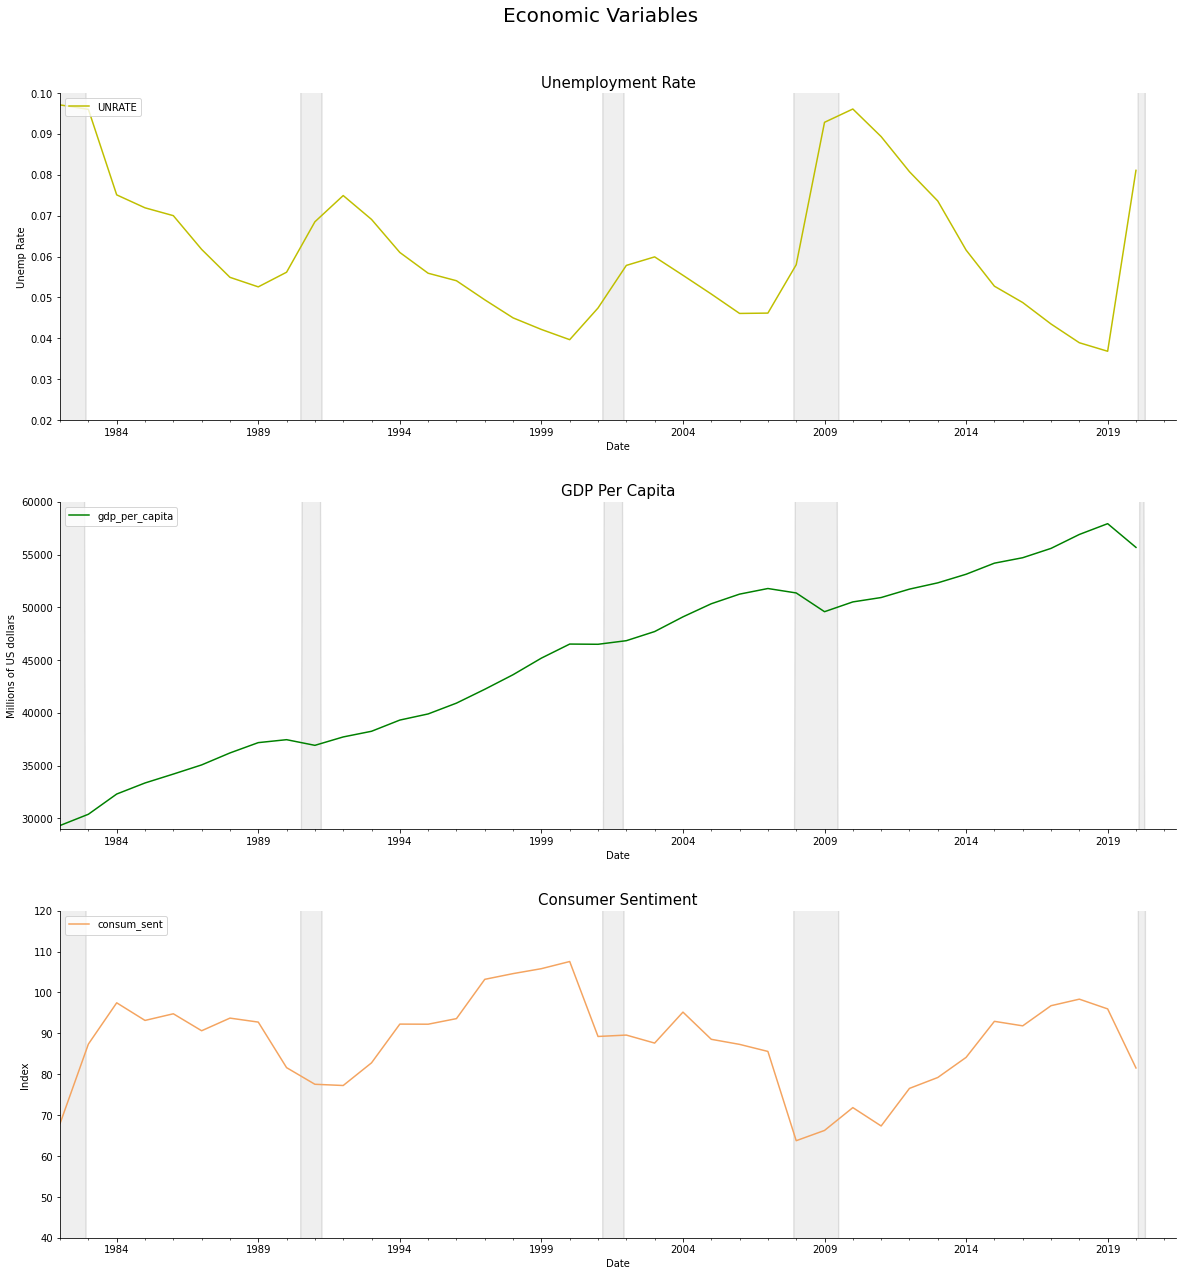

In [30]:
# Economic Variables

fig, axs = plt.subplots(3, 1, figsize=(20,20))

fig.suptitle(
    "Economic Variables", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
data_box_year[['UNRATE']].plot(ax=axs[0], color = ('y'))
axs[0].legend(loc='upper left', ncol=3, fancybox=True)
axs[0].set_xlim("1982-01-01", "2021-06-01")
axs[0].set_ylim(0.02, 0.1)

us_rec_scale["USREC"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
data_box_year[['gdp_per_capita']].plot(ax=axs[1], color = ('g'))
axs[1].legend(loc='upper left', ncol=3, fancybox=True)
axs[1].set_xlim("1982-01-01", "2021-06-01")
axs[1].set_ylim(29000, 60000)

us_rec_scale["USREC"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
data_box_year[['consum_sent']].plot(ax=axs[2], color = ('sandybrown'))
axs[2].legend(loc='upper left', ncol=3, fancybox=True)
axs[2].set_xlim("1982-01-01", "2021-06-01")
axs[2].set_ylim(40, 120)


axs[0].set_title("Unemployment Rate", fontsize=15)
axs[1].set_title("GDP Per Capita", fontsize=15)
axs[2].set_title("Consumer Sentiment", fontsize=15)

axs[0].axhline(0, color="k", alpha=0.3)
axs[1].axhline(0, color="k", alpha=0.3)
axs[2].axhline(0, color="k", alpha=0.3)

axs[0].set_ylabel("Unemp Rate")
axs[1].set_ylabel("Millions of US dollars")
axs[2].set_ylabel("Index")

for i in range(0,3):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)

Description of pattern of curve during recession:

The [unemployment rate](https://www.epi.org/newsroom/useful_definitions/) measures the share of workers in the labor force who do not currently have a job but are actively looking for work. 

[Gross Domestic Product](https://www.focus-economics.com/economic-indicator/gdp-per-capita) (GDP) per capita shows a country's GDP divided by its total population.

[Consumer sentiment](https://www.investopedia.com/terms/c/consumer-sentiment.asp) is a statistical measurement of the overall health of the economy as determined by consumer opinion. It takes into account people's feelings toward their current financial health, the health of the economy in the short-term, and the prospects for longer-term economic growth, and is widely considered to be a useful economic indicator.

1.   Unemployment rate: In all of the five recessions, the patteern has been that one year prior to the start of each recession period, there was an increase in the unemployment rate. Then, it took almost four years for the economy to recover in all of the five recessions. The largest and most rapid increase in unemployment rate occurred during the GFC.
2.   GDP per capita: There was an exponential increase in unemployment over time, where the GDP per capita in the US never decreasded until the last two recessions. After the GFC, it took 2 years for the GDP per capita to recover to the previous level. 
3.   Consumer sentiment: The index decreased at least 12 points prior to each of the five recessions. In all the cases, households anticipated the recessions, and that can be seen by their change in behavior on average one year and six months prior to the event. One thing to notice is that the consumer sentiment level prior to the Dotcom recession was never recovered. Lower levels of confidence impy higher uncertainty in the economy.

### 2.1 Economic Variables and The Demand For Movies


Text(1981-09-01, 4250, 'The Energy Crisis Recession')

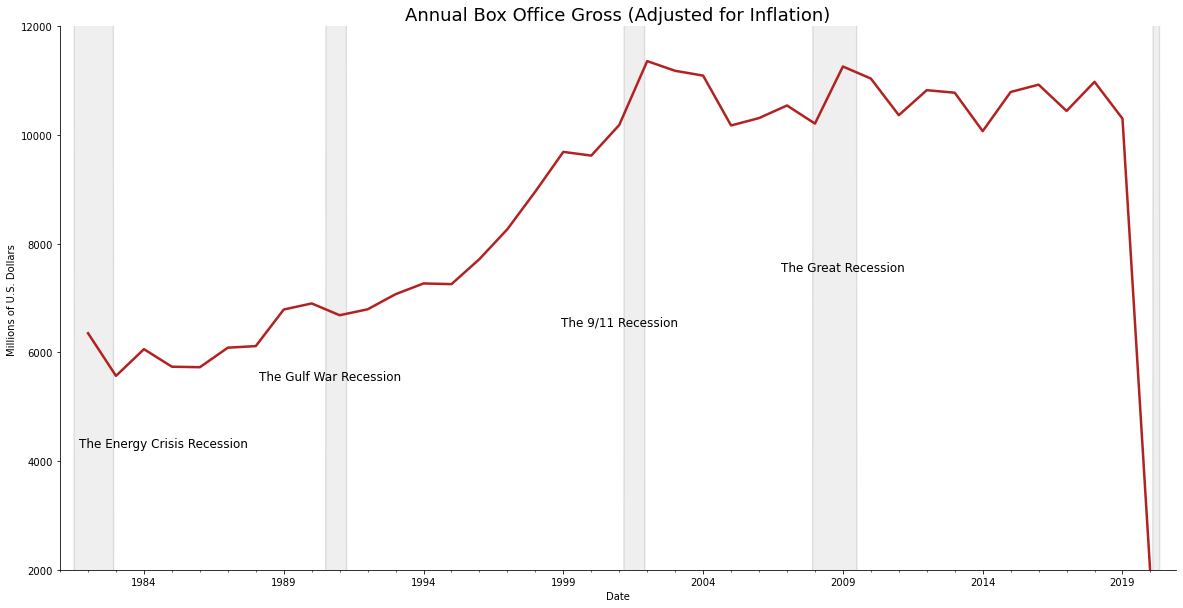

In [31]:
# Annual Box Office Gross (Adjusted for Inflation)
fig, axs = plt.subplots(figsize=(20,10))

us_rec_scale["USREC"].plot.area(ax=axs, alpha=0.12, color="gray", label=str())

data_box_year['gross'].plot(
    color = ('firebrick'), 
    ax=axs, 
    label="Gross",
    linewidth = 2.5)

plt.xlim("1978-01-01", "2021-01-01")
plt.xlim("1981-01-01", "2020-12-31")
plt.ylim(2000,12000)

axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)
axs.set_title(
    "Annual Box Office Gross (Adjusted for Inflation)",
    fontsize = 18)
axs.set_ylabel("Millions of U.S. Dollars ")

axs.annotate(
    "The Great Recession",
    xy = ("2009-01-01", 7500),
    fontsize=12,
     horizontalalignment="center")

axs.annotate(
    "The 9/11 Recession",
    xy = ("2001-01-01", 6500),
    fontsize=12,
     horizontalalignment="center")

axs.annotate(
    "The Gulf War Recession",
    xy = ("1990-09-01", 5500),
    fontsize=12,
     horizontalalignment="center")

axs.annotate(
    "The Energy Crisis Recession",
    xy = ("1981-09-01", 4250),
    fontsize=12,
     horizontalalignment="left")

Description of curve during recessions

1.   The Energy Crisis Recession: There is a decrease in gross revenues from approximately 61000 to 58000 millions of US dollars. Then, the revenues stays constant until 1988, where it reaches again the pre-recessionary values. So we can say that it took almost 7 years to the movie industry to generate the same amount of revenues as in 1981. After reaching those values, the gross revenues peaked at 65000 millions of US dollars in 1990, just before entering into the next recession.

2.   The Gulf War Recession: Early in 1990 the gross revenues decreased only 1000 millions of US dollars before the second recession of our analysis started. However, gross revenues started increasing at the beginning of 1991, before the end of the second recession. Revenues increased relatively slow reaching 66000 millions of US dollars. Then 4 years after the second recession ended, in 1995, there was a rapid increase in gross revenues of the film industry. The values reached in 1999 were almost 10000 millions of US dollars.
3.   The 9/11 Recession: Those revenues continued increasing until 2002, where the revenues where 11700 millions of US dollars. Higher than ever in history. However, after those all time highs and after the Dotcom bubble burst, the was a decrease in revenues until 10000 millions of US dollars in 2008, at the beginning of the Great Recession.
4.   The Great Recession: During the Great Recession, gross revenues increased until 11500 millions of US dollars, but again, just like afteer the Dotcom recession, the gross revenues decreased until approximately 10000 millions of US dollars. After that, the gross revenues stayed constant around 11200 millions of US dollars until 2019. Then From 2019 to 2020 there has been a major decrease never seen in the film industry, where gross revenues from cinema entertainment fell from 10000 to 2000 millions of US dollars.



The variable for cumulative revenue is "gross".


/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


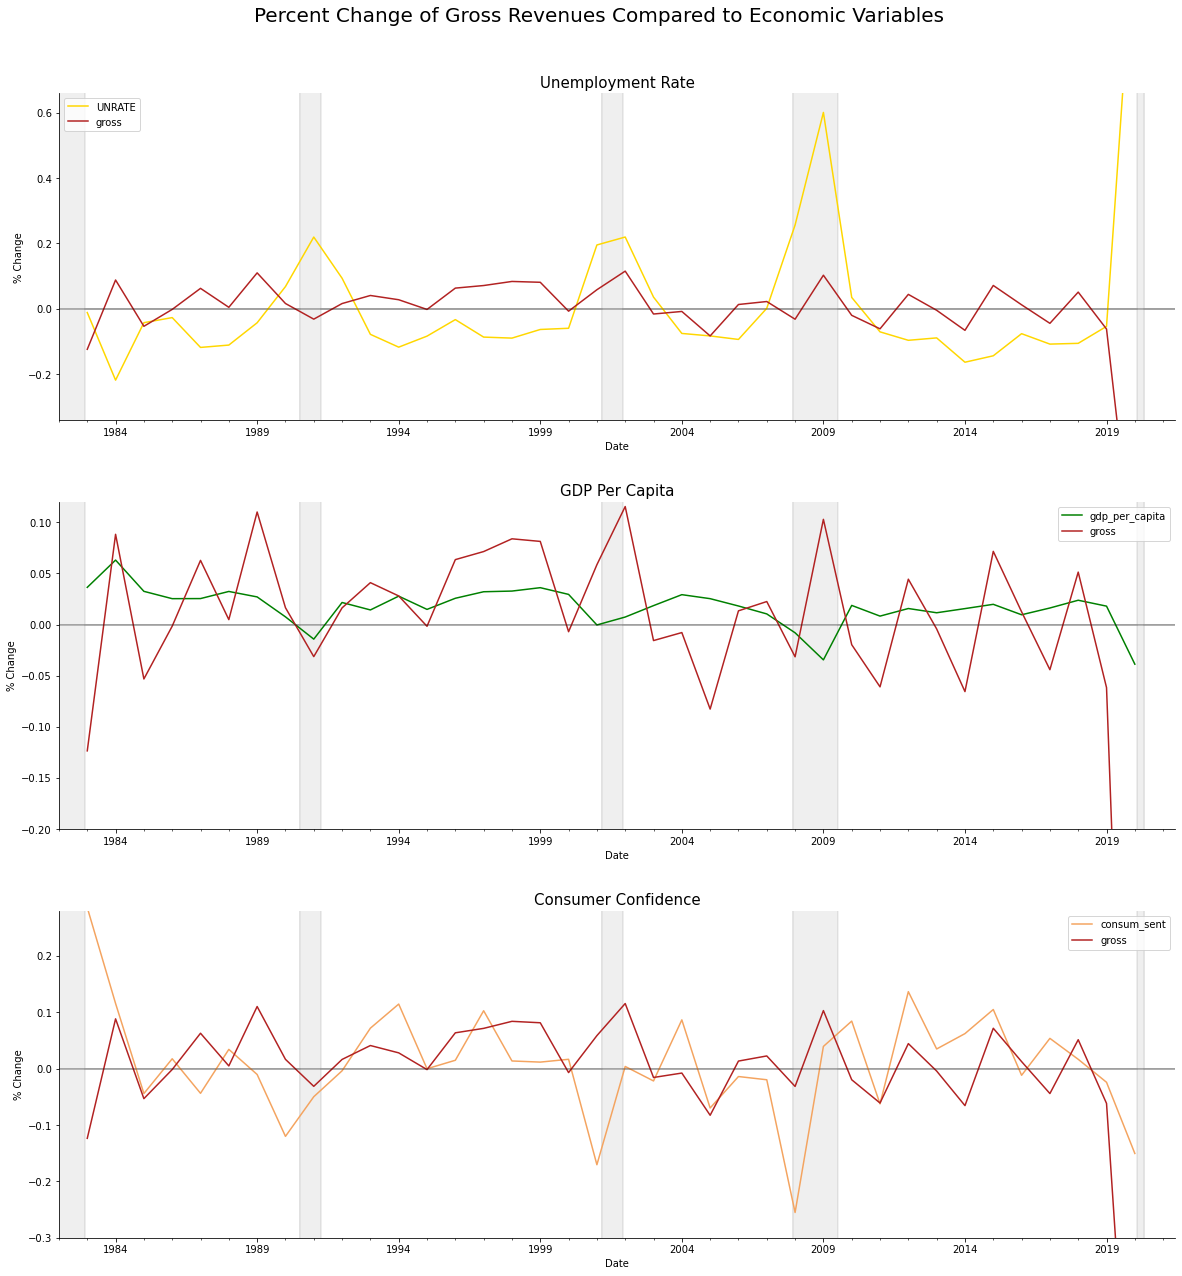

In [47]:
# Gross Revenues Compared to Economic Variables - Percent Changes

fig, axs = plt.subplots(3, 1, figsize=(20,20))

fig.suptitle(
    "Percent Change of Gross Revenues Compared to Economic Variables", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
data_box_year_pct[['UNRATE', 'gross']].plot(ax=axs[0], color = ('gold','firebrick'))
axs[0].legend(ncol=1, fancybox=True)
axs[0].set_xlim("1982-01-01", "2021-06-01")
axs[0].set_ylim(-0.34, 0.66)

us_rec_scale["USREC"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
data_box_year_pct[['gdp_per_capita', 'gross']].plot(ax=axs[1], color = ('green','firebrick'))
axs[1].legend(ncol=1, fancybox=True)
axs[1].set_xlim("1982-01-01", "2021-06-01")
axs[1].set_ylim(-0.2, 0.12)

us_rec_scale["USREC"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
data_box_year_pct[['consum_sent', 'gross']].plot(ax=axs[2], color = ('sandybrown','firebrick'))
axs[2].legend(ncol=1, fancybox=True)
axs[2].set_xlim("1982-01-01", "2021-06-01")
axs[2].set_ylim(-0.3, 0.28)


axs[0].set_title("Unemployment Rate", fontsize=15)
axs[1].set_title("GDP Per Capita", fontsize=15)
axs[2].set_title("Consumer Confidence", fontsize=15)

axs[0].axhline(0, color="k", alpha=0.3)
axs[1].axhline(0, color="k", alpha=0.3)
axs[2].axhline(0, color="k", alpha=0.3)

axs[0].set_ylabel("% Change")
axs[1].set_ylabel("% Change")
axs[2].set_ylabel("% Change")

axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)
axs[2].spines["top"].set_visible(False)

Description of patterns of curves during recessions

The percent rate change on gross revenues, that apperas in all three plots, had two positive changes after the first two recessions, and three negative changes after the Dotcom recession, GFC and during the 2020 recession. We can see the same pattern as in the annual gross revenue adjusted for inflation graph. 

1.   Percent change of unemployment rate and gross revenues: Unemployment rate has a countercyclical trend. Percent change of unemployment rate has a negative relationship with the percent change of gross revenues most of the times. Only during the Dotcom recession and the GFC they moved with a positive relationship.
2.   Percent change of GDP per capita rate and gross revenues: GDP per capita rate has a procyclical trend. The percent change of GDP per capita stays more constant over time with respect to the percent change of gross revenues.
3.   Percent change of consmer sentiment rate and gross revenues: Consumer sentiment has a procyclical trend. From the percent change graph, we can see that the variables move independent from each other over time.




### 2.2 Economic variables and the SUPPLY side of Movies





Text(1981-09-01, 350, 'The Energy Crisis Recession')

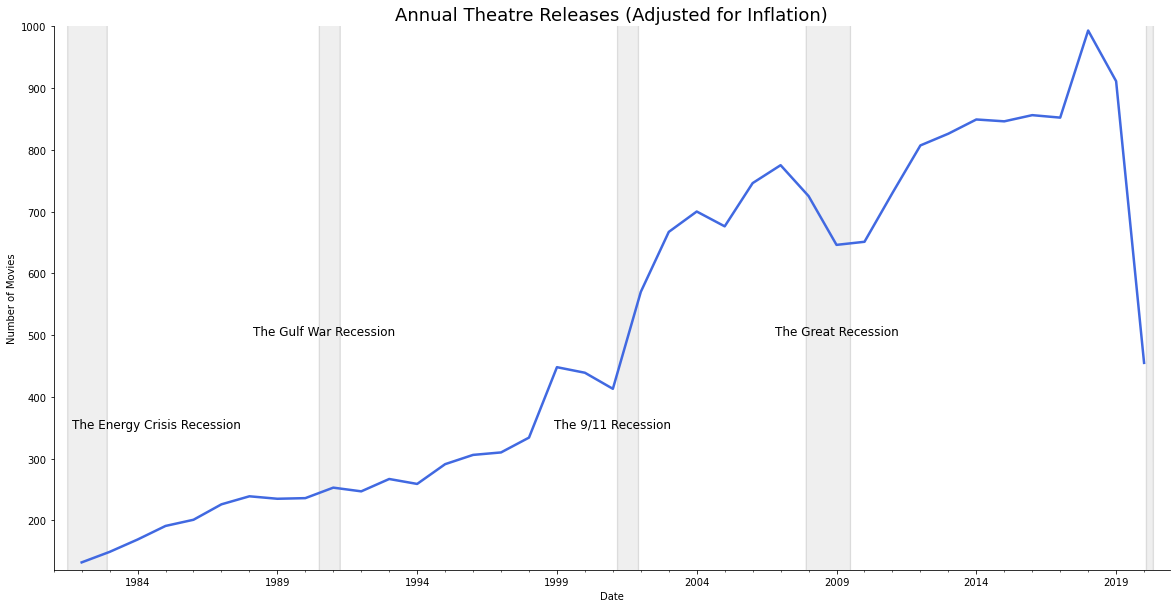

In [33]:
# Annual theater releases (adjusted for inflation)

fig, axi = plt.subplots(figsize=(20,10))

us_rec_scale["USREC"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())

data_box_year['Releases'].plot(
    color = ('royalblue'), 
    ax=axi, 
    label="Releases",
    linewidth = 2.5)

plt.xlim("1978-01-01", "2021-01-01")
plt.xlim("1981-01-01", "2020-12-31")
plt.ylim(120,1000)

axi.spines["right"].set_visible(False)
axi.spines["top"].set_visible(False)
axi.set_title(
    "Annual Theatre Releases (Adjusted for Inflation)",
    fontsize = 18)
axi.set_ylabel("Number of Movies")

axi.annotate(
    "The Great Recession",
    xy = ("2009-01-01", 500),
    fontsize=12,
     horizontalalignment="center")

axi.annotate(
    "The 9/11 Recession",
    xy = ("2001-01-01", 350),
    fontsize=12,
     horizontalalignment="center")

axi.annotate(
    "The Gulf War Recession",
    xy = ("1990-09-01", 500),
    fontsize=12,
     horizontalalignment="center")

axi.annotate(
    "The Energy Crisis Recession",
    xy = ("1981-09-01", 350),
    fontsize=12,
     horizontalalignment="left")

Description of curve during recession

1.   Energy Crisis Recession: No apparent effect of recession on movie releases that increase exponentially starting at 110 movies in 1981.
2.   Gulf War Recession: After this recession, it took one year for the film industry to release more movies than before the recession period. Then, the number of releases stayed somewhat constant and only after 3 year of the recession it started growiing exponentially agaiin, reaching the number of releases 420 movies by 1981.
3.   9/11 Recession: No apparent effect of the Dotcom recession on movie releases that continued growing exponentially reaching 730 by 2007.
4.   The Great Recession: The number of releases in the movie industry started decreasing before the GFC, and when the recession period started, the decrease was even steeper. Afterwards, the film industry recovered in less than a year and the exponential grow started again until 2018, reaching the number of 1000 that year.
5.   From 2020-03-01 to 2020-04-01: There was a massive decrease in movie releases prior to the Covid recession. The values are equal to the movie releases in 2001 during the Dotcom recession: 450 movies per year.

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


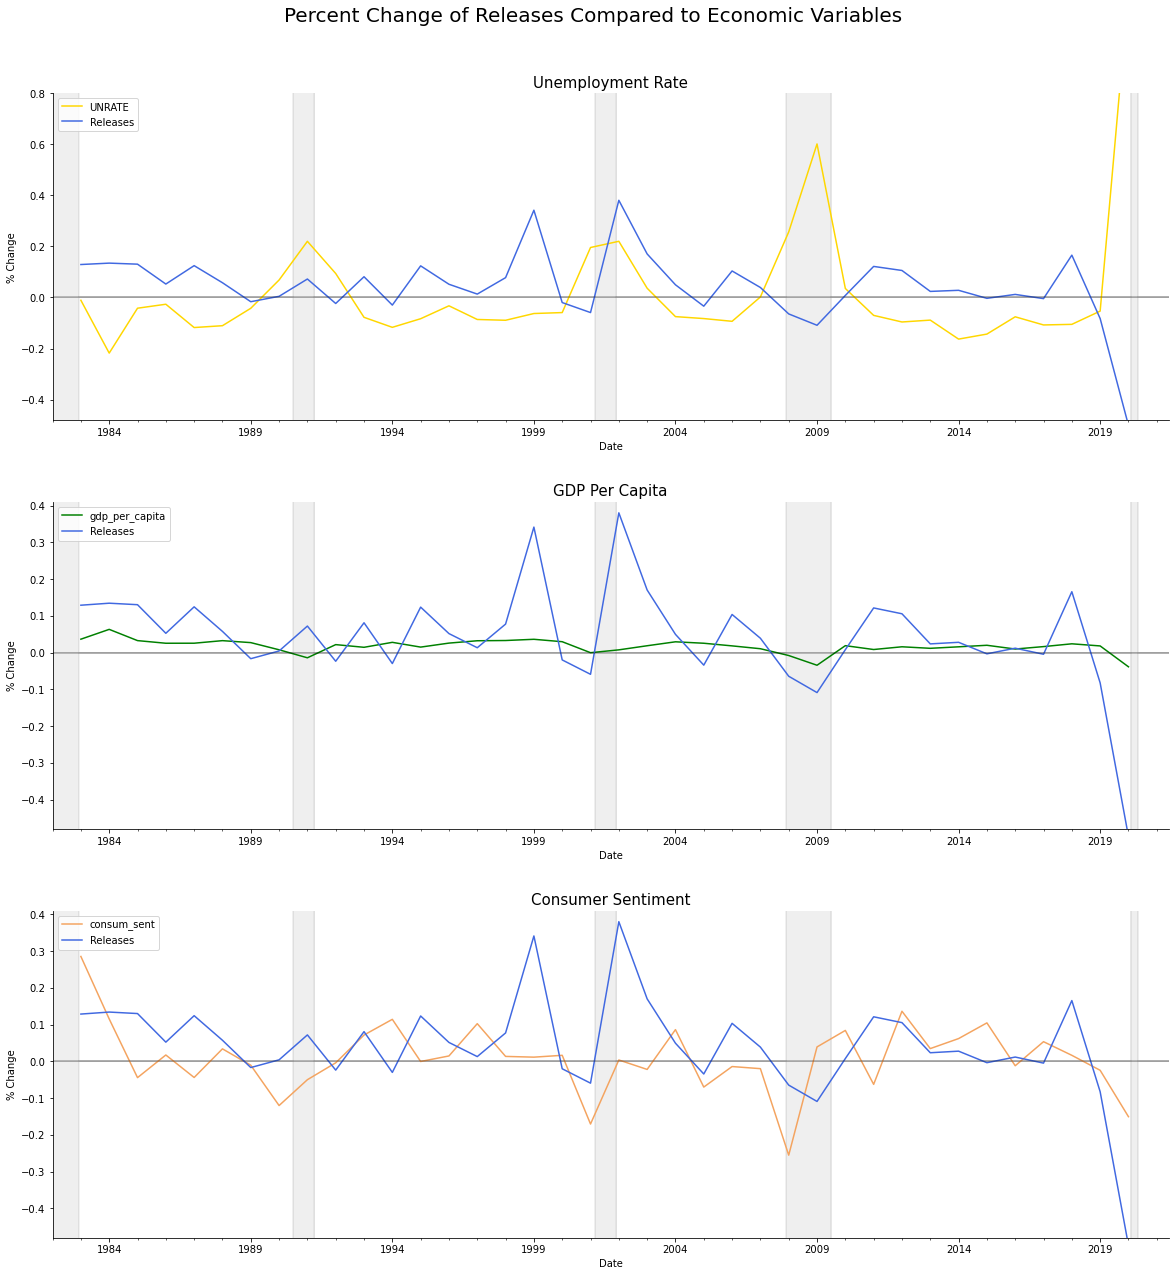

In [48]:
# Number of Releases Compared to Economic Variables - Percent Changes

fig, axs = plt.subplots(3, 1, figsize=(20,20))

fig.suptitle(
    "Percent Change of Releases Compared to Economic Variables", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
data_box_year_pct[['UNRATE', 'Releases']].plot(ax=axs[0], color = ('gold','royalblue'))
axs[0].legend(loc='upper left', fancybox=True)
axs[0].set_xlim("1982-01-01", "2021-06-01")
axs[0].set_ylim(-0.48, 0.8)

us_rec_scale["USREC"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
data_box_year_pct[['gdp_per_capita', 'Releases']].plot(ax=axs[1], color = ('green','royalblue'))
axs[1].legend(loc='upper left', fancybox=True)
axs[1].set_xlim("1982-01-01", "2021-06-01")
axs[1].set_ylim(-0.48, 0.41)

us_rec_scale["USREC"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
data_box_year_pct[['consum_sent', 'Releases']].plot(ax=axs[2], color = ('sandybrown','royalblue'))
axs[2].legend(loc='upper left', fancybox=True)
axs[2].set_xlim("1982-01-01", "2021-06-01")
axs[2].set_ylim(-0.48, 0.41)


axs[0].set_title("Unemployment Rate", fontsize=15)
axs[1].set_title("GDP Per Capita", fontsize=15)
axs[2].set_title("Consumer Sentiment", fontsize=15)

axs[0].axhline(0, color="k", alpha=0.3)
axs[1].axhline(0, color="k", alpha=0.3)
axs[2].axhline(0, color="k", alpha=0.3)

axs[0].set_ylabel("% Change")
axs[1].set_ylabel("% Change")
axs[2].set_ylabel("% Change")

axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)
axs[2].spines["top"].set_visible(False)

Description of patterns of curves during recessions

The percent change on movie releases, that apperas in all three plots, reacted differently after all the five recessions. We can see that the largest percent changes of releases occured before, during, and after the Dotcom recession. 

1.   Percent change of unemployment rate and movie releases: Unemployment rate has a countercyclical trend. Percent change of unemployment rate has a negative relationship with the percent change of movie release most of the times. Only during the second and the Dotcom recessions they moved with a positive relationship.
2.   Percent change of GDP per capita rate and movie releases: GDP per capita rate has a procyclical trend. The percent change of GDP per capita stays more constant over time with respect to the percent change of  movie release.
3.   Percent change of consmer sentiment rate and movie releases: Consumer sentiment has a procyclical trend. From the percent change graph we can see that the variables move independent from each other over time.




### 2.3 Genres

In this sub-section, we attempt to analyze how the economy may have affected tastes in certain genres. The initial hypothesis is that during hard economic times people will turn to more lighthearted movies as a distraction and move away from more serious genres. 

To test this theory we first analyze the super categorized genres with line graphs over time to see general trends in total genres produced and their percent change in growth. To get a more detailed look at how specific genres changed over time we then repeated the process by looking at the trends of similar genres.

Lastly, two stacked bar charts were produced to see how the proportion of genres produced over time has changed.

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


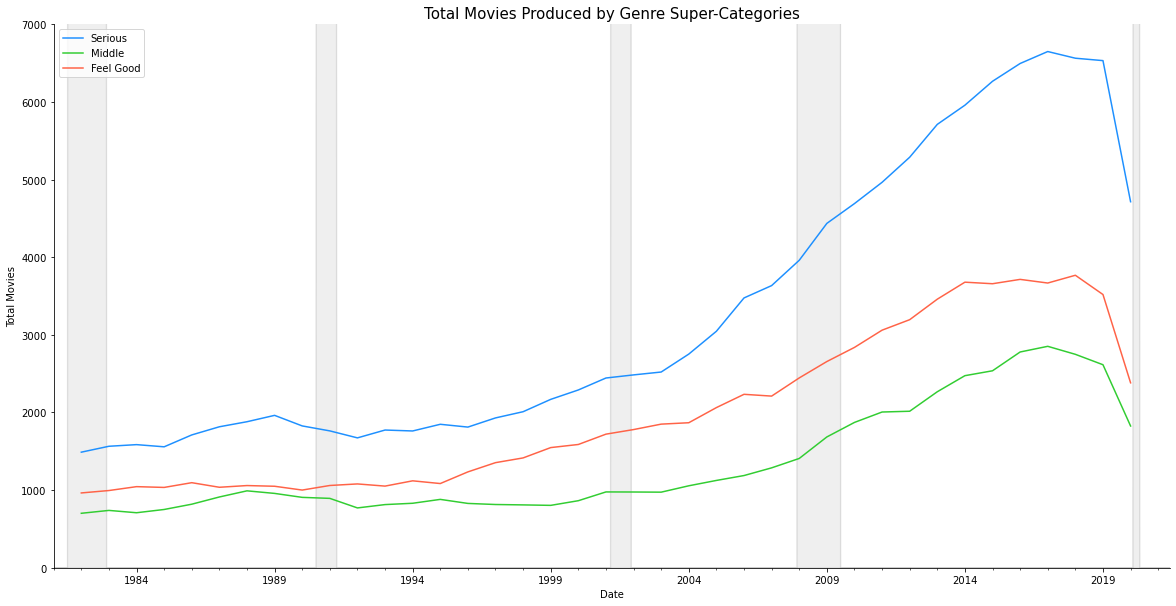

In [35]:
# Genres graphed by sum of total super genres produced
fig, ax = plt.subplots(figsize = (20,10))

us_rec_scale["USREC"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
genres_tot[three_cats].plot(ax=ax, color=comb_cats_c)
ax.legend(loc='best')
ax.set_xlim("1981-01-01", "2021-06-01")
ax.set_ylim(0, 7000)

ax.set_title("Total Movies Produced by Genre Super-Categories", fontsize=15)

for i in range(0,4):
    ax.set_ylabel("Total Movies")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

Observations from Total Super-Categories:
1. All three super categories increase significantly from 1982-2019 while periods of negative growth generally last only 2-3 years at most. This shows us that no genre has really disappeared in popularity over time. 
2. Serious movies are clearly the most common type of genre to make. This could be because they are by far the most popular type of genre, but given this data only measures the total genres made not the box office results of the genres, it could be because serious movies are simply easier and cheaper to make.
3. In the periods following a recession no category ever sees more than a period of negative growth.
4. Feel good genres are surprisingly number 2 in total produced surpassing Middle genres by a wide margin starting in 1995.
5.  Middle genres came close to converging on Feel Good genres in the late '80s but then started dropping even before the Gulf War recession. This could indicate that factors outside of the economy led to a decline in the production of Middle genres. 
6. The Middle genres appear to stagnate for a lot of the '90s while the other two categories increase. This shift occurs right in between two different recessions making it difficult to say if this has anything to do with the economy.
7. All the categories see a steep positive spike in production starting around 2003-04 and widely expanded during the great recession. This is most likely due to the adoption of digital technology in the 2000s which made cameras cheaper and more widely available to low-budget filmmakers.

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


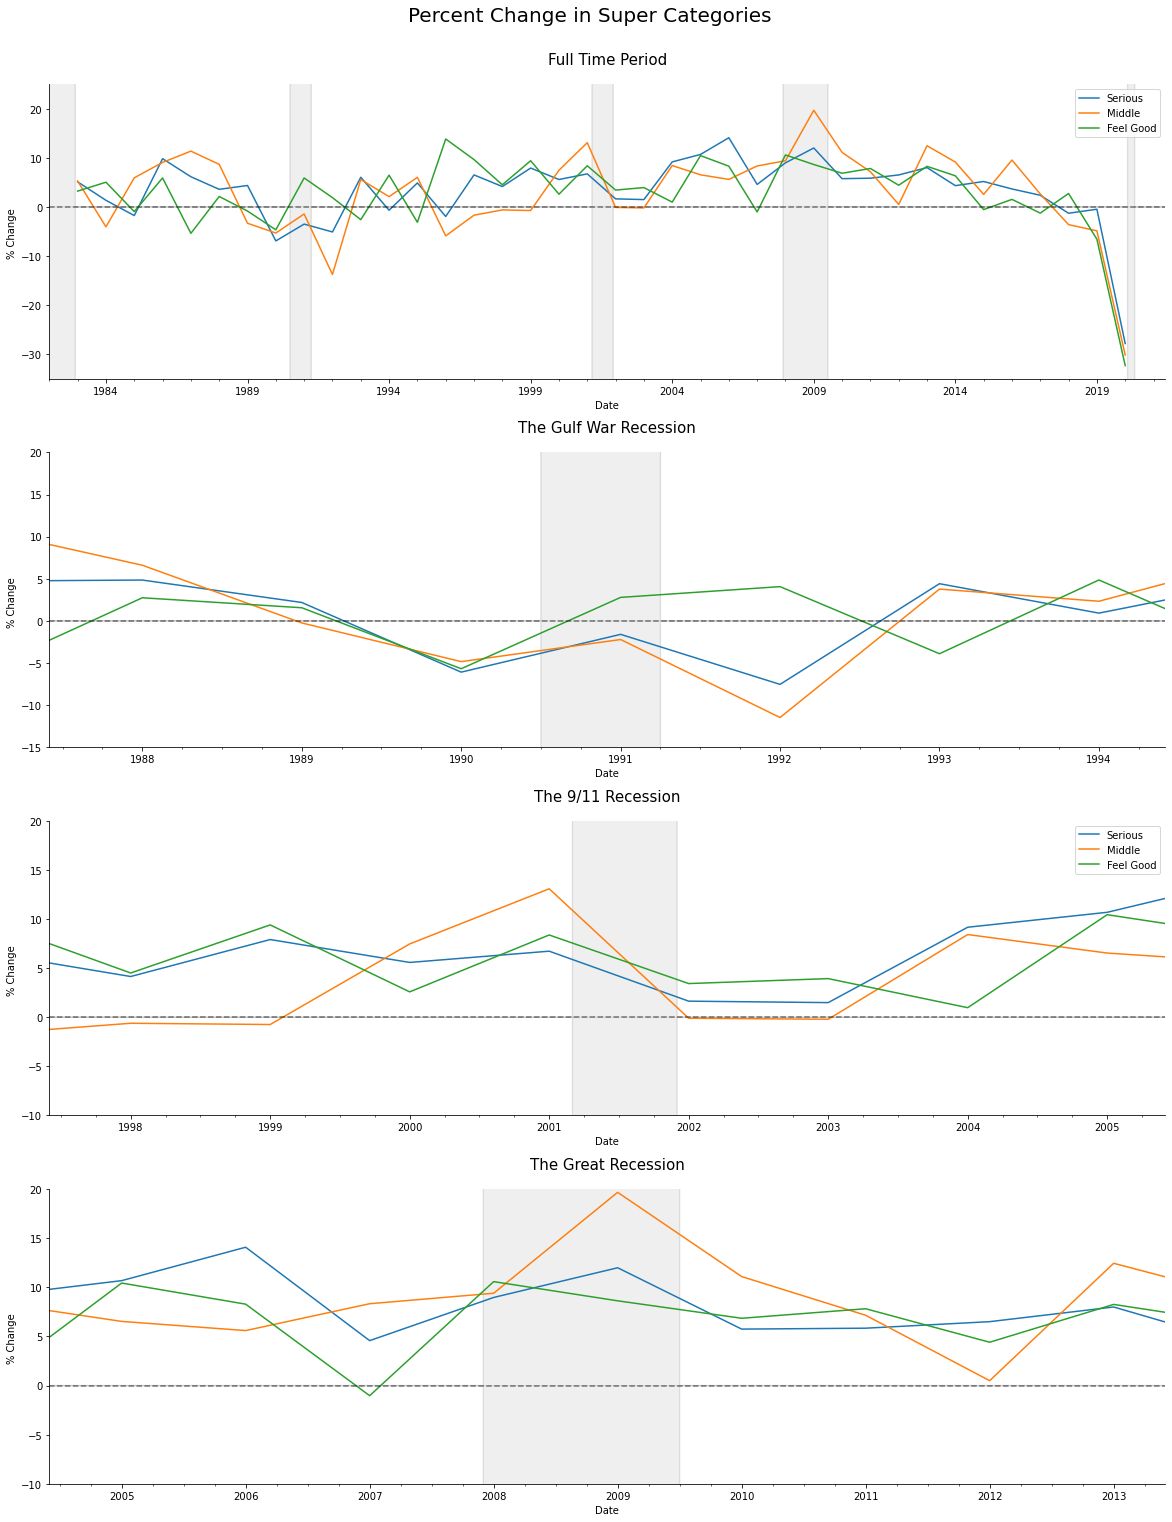

In [36]:
# Genres graphed by percent change
fig, axi = plt.subplots(4,1, figsize = (20,24))

us_rec_scale["USREC"].plot.area(ax=axi[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[0], alpha=0.12, color="gray", label=str())
genres_share_pct[three_cats].plot(ax=axi[0])
axi[0].legend(loc='best')
axi[0].set_xlim("1982-01-01", "2021-06-01")
axi[0].set_ylim(-35, 25)

us_rec_scale["USREC"].plot.area(ax=axi[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[1], alpha=0.12, color="gray", label=str())
genres_pct[three_cats].plot(ax=axi[1])
axi[1].get_legend().remove()
axi[1].set_xlim("1987-06-01", "1994-06-01")
axi[1].set_ylim(-15, 20)

us_rec_scale["USREC"].plot.area(ax=axi[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[2], alpha=0.12, color="gray", label=str())
genres_share_pct[three_cats].plot(ax=axi[2])
axi[2].legend(loc='best')
axi[2].set_xlim("1997-06-01", "2005-06-01")
axi[2].set_ylim(-10, 20)

us_rec_scale["USREC"].plot.area(ax=axi[3], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[3], alpha=0.12, color="gray", label=str())
genres_share_pct[three_cats].plot(ax=axi[3])
axi[3].get_legend().remove()
axi[3].set_xlim("2004-06-01", "2013-06-01")
axi[3].set_ylim(-10, 20)


axi[0].set_title("Full Time Period", fontsize=15, pad=20)
axi[1].set_title("The Gulf War Recession", fontsize=15, pad=20)
axi[2].set_title("The 9/11 Recession", fontsize=15, pad=20)
axi[3].set_title("The Great Recession", fontsize=15, pad=20)

fig.suptitle(
    "Percent Change in Super Categories", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.935, wspace=None, hspace=.25)

for i in range(0,4):
    axi[i].axhline(0, color="k", alpha=0.5, linestyle="--")
    axi[i].set_ylabel("% Change ")
    axi[i].spines["right"].set_visible(False)
    axi[i].spines["top"].set_visible(False)

In [37]:
jeff = np.std(genres_pct[three_cats])
jeff1 = np.std(genres_pct["Middle"])
jeff2 = np.std(genres_pct["Feel Good"])
print(f"Standard Deviation of Super Genres")
print(f"{jeff}")

Standard Deviation of Super Genres
Serious      6.798698
Middle       8.255764
Feel Good    7.649302
dtype: float64


Observations:

Full Period: 
1. Middle genres experience the highest variability followed by Feel Good and Serious genres, the opposite order of most produced. 
2. All three categories seem to move with the same pattern of growth roughly half of the time, but to different degrees of growth. 
3. All three growth rates decrease in volatility over time, especially after the Great Recession. This could lead to the possibility that recessions make movie studios more careful with their money causing them to be safer and more consistent with their genre production. Or, as this is a 40-year trend, it could mean movie studios have been able to learn from consumer data and make movies more accurately to consumer trends. 
4. The most significant split in growth occurs in 1996 with the Feel Good genres seeing significant growth with the other two experiencing negative growth. The fact this occurs right in between two recessions makes it difficult to say that it was linked to economic factors.
5. Middle genres seem to move in a similar direction to Serious genres more other than with the Feel Good genres. This could imply more movies contain a mix of serious and middle genres than middle and feel good.

Gulf War Recession:
1. All three super categories begin to decrease before this recession while only the Feel Good genres increases in this recession. Feel Good then continues to increase in growth for one period post-recession while the other two categories decrease even further. Two years after though we see a reversal in all the growth rates. The rates then flip again three periods after the recession. This would imply Feel Good genres did do better in the recession but did not experience any continued long-term effect. Therefore the recession may have had a short-term effect in boosting the desire to see Feel Good movies versus darker ones, but it did not cause a long-term change in the market.

9/11 Recession:
1. To note, this is a very difficult recession to analyze because of the cultural impact that 9/11 had on the American psyche. That being said, all three categories experienced decent growth before the recession and then all three immediately decreased in their growth rates during the recession. They then only grew slightly the following year before hitting higher growth two periods on. This may imply studios were hesitant to change up the status quo after this recession. 
2. Feel-good genres seemed to be going through an interesting cyclical pattern before and after the recession. However, given that growth slows for two periods following the recession before returning to the normal cycle it could indicate the recession had an effect. 
3. Serious and Middle genres experienced one period of very low growth following the recession after previously growing before the recession. This could indicate a short-term drop in interest, but 9/11 is more likely to be the primary cause of this shift. The world was probably dark and violent enough for most people at that time. They didn't need to be watching serious movies to get that feeling. 

Great Recession:
1. All three categories see high growth rates above 10% during this recession after having a decrease in growth in the period proceeding the recession. Middle genres see the highest growth as ~16.5% indicating studios believed most people wanted to see a mix of fun and serious. Growth then declines in all three categories following the recession and doesn't reach nearly the same highs again. This could mean that people wanted to see any type of movie in the recession and stopped caring about them after. More likely, the studious wanted to be careful with their finances after the recession and slowed production a bit. 
2. This chart points to the recession having a short-term positive impact on movie production as a whole. However, this chart contradicts the annual releases chart. This either means that every movie released during this period was made up of multiple genres inflating the numbers, or a significant number of movies were not released in theaters. 
3. In the long run the impact of this recession seems to be slightly negative as studios probably wanted to get more consistent with their releases to be safer with their cash. 

As a whole, it's difficult to say that every recession leads to an increase in one genre over the other. Generally, all three categories move together in a recession and diverge from each other more frequently between recessions. 

/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


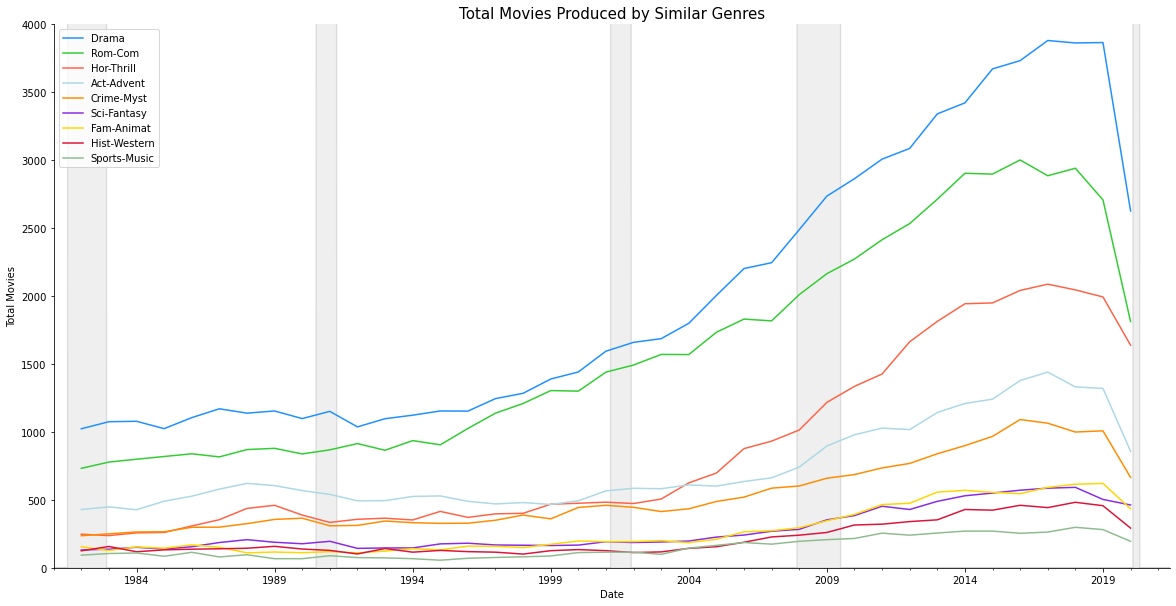

In [38]:
# Genres graphed by percent change
fig, ax = plt.subplots(figsize = (20,10))

us_rec_scale["USREC"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax, alpha=0.12, color="gray", label=str())
genres_tot[comb_cats].plot(ax=ax, color=comb_cats_c)
ax.legend(loc='best')
ax.set_xlim("1981-01-01", "2021-06-01")
ax.set_ylim(0, 4000)

ax.set_title("Total Movies Produced by Similar Genres", fontsize=15)

for i in range(0,4):
    ax.set_ylabel("Total Movies")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

Total Movies produced by Similar Genres:
1. Drama dominates eveything. This is probably why the Serious categoy was the most produced in the pervious charts. The second largest category is Romance-Comedies followed by Horror-Thrillers which passed Action-Avednture in the early 2000's to be a clear third. There is then a bit of a gap to Action-Adventure in fourth and Crime and Mystery movies in fifth that begins widening in the mid-2000s (the gap with the top two and the rest of the categories started widening in the mid '90s). This could mean suppliers may have found the top three genres to be the most profitable and so they shifted to producing those the most. Or it could be becuase the top three genres are generally the cheeper to make. Again, as this occurs between recessions so it does not seem like the economy had a major impact on this decision. 

2. In sixth and seventh SciFi-Fantasy and Family-Animation seem to follow each other very closely until the 2010s. History-Western largely stays above Sports-Music in the eigth and ninth most produced genres.

3. Other than showing the specifcs this graph follows the same pattern as the super categories chart. Again, no genre ever seems to fall completely out of favor over time as all increase in the long run.

In [39]:
import matplotlib.patches as mpatches

top3_cats = ["Drama", "Rom-Com", "Hor-Thrill"]
mid2_cats = ["Act-Advent", "Crime-Myst"]
smid2_cats = ["Fam-Animat","Sci-Fantasy"]
bot3_cats = ["Hist-Western", "Sports-Music"]

top3_cats_c = ["dodgerblue", "limegreen", "tomato"]
mid2_cats_c = ["lightblue", "darkorange"]
smid2_cats_c = ["blueviolet", "gold"] 
bot3_cats_c = ["crimson", "darkseagreen"]

In [40]:
patch_sport = mpatches.Patch(color="crimson", label ="Hist-Western")
patch_his = mpatches.Patch(color="darkseagreen", label ="Sports-Music")
patch_Dra = mpatches.Patch(color= "dodgerblue", label = "Drama")
patch_Rom = mpatches.Patch(color= "limegreen", label = "Rom-Com")
patch_Hor = mpatches.Patch(color= "tomato", label = "Hor-Thrill")
patch_Act = mpatches.Patch(color= "lightblue", label = "Act-Advent")
patch_Cri = mpatches.Patch(color= "darkorange", label = "Crime-Myst")
patch_Fam = mpatches.Patch(color= "blueviolet", label = "Fam-Animat")
patch_Sci = mpatches.Patch(color= "gold", label = "Sci-Fantasy")


/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/Users/jackbrennan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1358: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


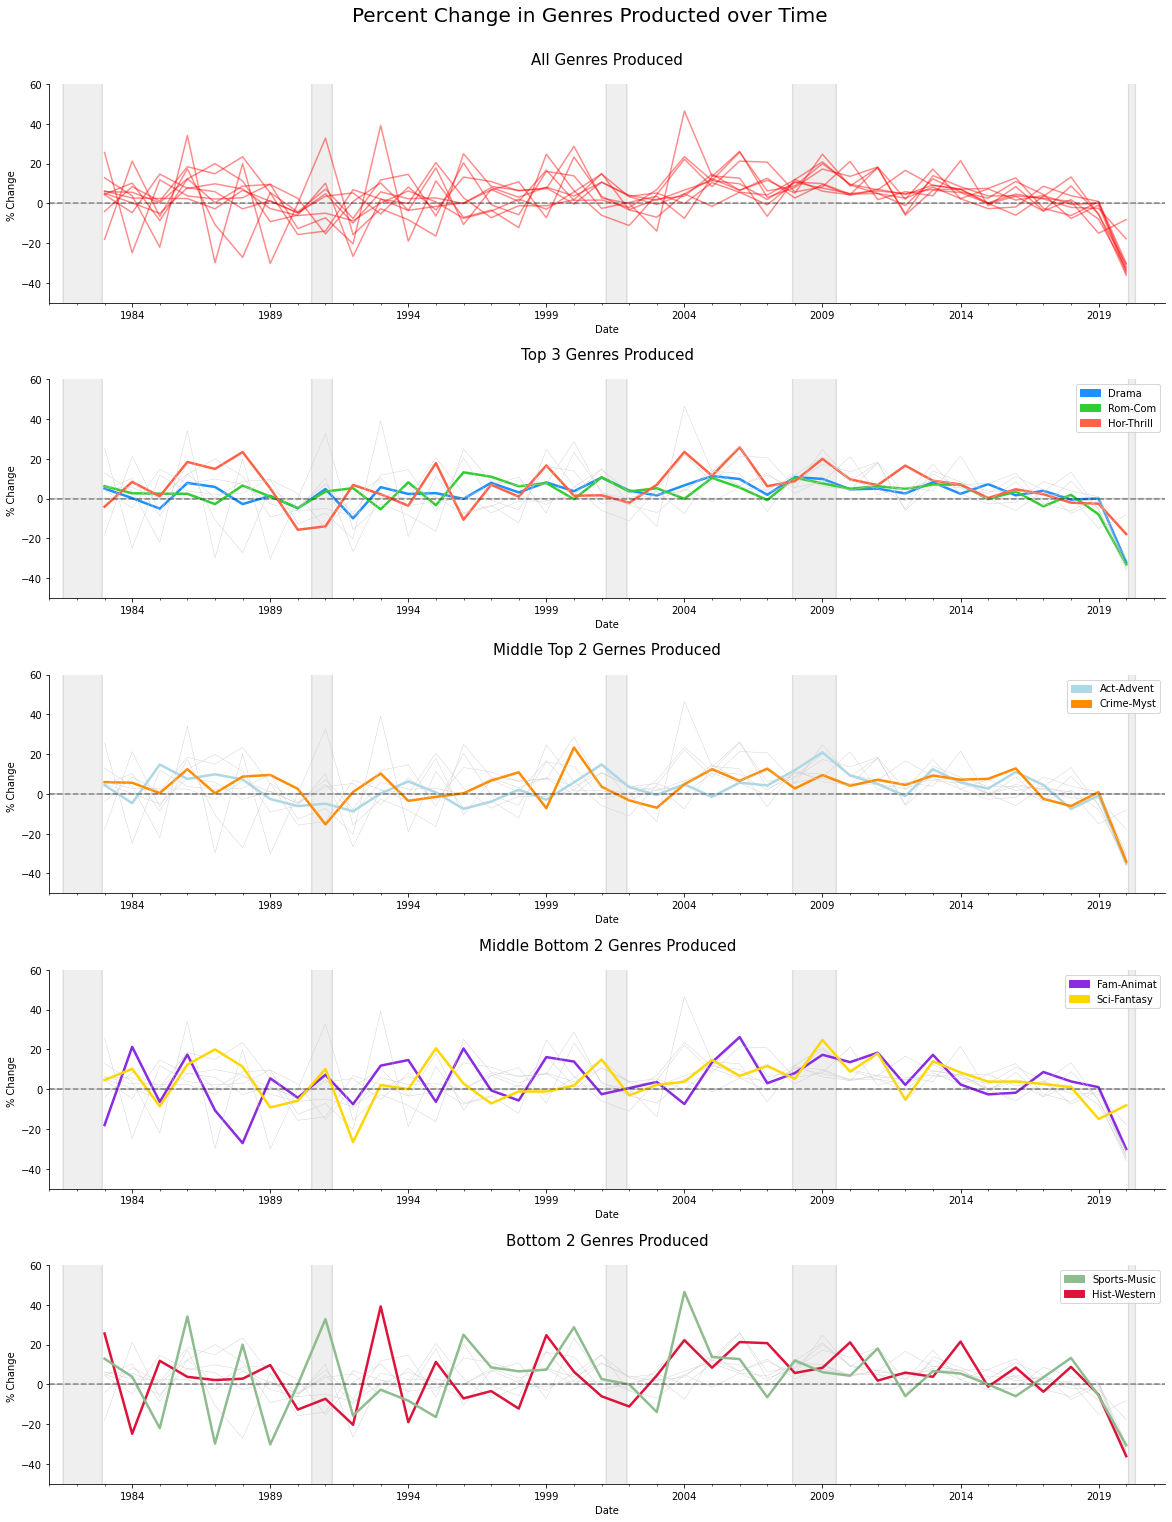

In [49]:
fig, ax = plt.subplots(5,1, figsize = (20,24))

us_rec_scale["USREC"].plot.area(ax=ax[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[0], alpha=0.12, color="gray", label=str())
genres_share_pct[top3_cats].plot(ax=ax[0], color="r", alpha=.45, lw=1.5)
genres_share_pct[smid2_cats].plot(ax=ax[0], color="r", alpha=.45, lw=1.5, label=str())
genres_share_pct[bot3_cats].plot(ax=ax[0], color="r", alpha=.45, lw=1.5, label=str())
genres_share_pct[mid2_cats].plot(ax=ax[0], color="r", alpha=.45, lw=1.5, label=str())
ax[0].get_legend().remove()
ax[0].set_xlim("1981-01-01", "2021-06-01")
ax[0].set_ylim(-50, 60)

us_rec_scale["USREC"].plot.area(ax=ax[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[1], alpha=0.12, color="gray", label=str())
genres_share_pct[top3_cats].plot(ax=ax[1], color = top3_cats_c, linewidth=2.5)
genres_share_pct[smid2_cats].plot(ax=ax[1], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_share_pct[bot3_cats].plot(ax=ax[1], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_share_pct[mid2_cats].plot(ax=ax[1], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
ax[1].legend(handles = [patch_Dra, patch_Rom, patch_Hor])
ax[1].set_xlim("1981-01-01", "2021-06-01")
ax[1].set_ylim(-50, 60)

us_rec_scale["USREC"].plot.area(ax=ax[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[2], alpha=0.12, color="gray", label=str())
genres_share_pct[top3_cats].plot(ax=ax[2], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_share_pct[mid2_cats].plot(ax=ax[2], color = mid2_cats_c, linewidth=2.5)
genres_share_pct[smid2_cats].plot(ax=ax[2], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_share_pct[bot3_cats].plot(ax=ax[2], color=[(0.8, 0.8, 0.8)], lw=0.4, label=[str(),str()])
ax[2].legend(handles = [patch_Act, patch_Cri])
ax[2].set_xlim("1981-01-01", "2021-06-01")
ax[2].set_ylim(-50, 60)

us_rec_scale["USREC"].plot.area(ax=ax[3], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[3], alpha=0.12, color="gray", label=str())
genres_share_pct[top3_cats].plot(ax=ax[3], color=[(0.8, 0.8, 0.8)], lw=0.4, label=False)
genres_share_pct[mid2_cats].plot(ax=ax[3], color=[(0.8, 0.8, 0.8)], lw=0.4, label=False)
genres_share_pct[smid2_cats].plot(ax=ax[3], color = smid2_cats_c, linewidth=2.5)
genres_share_pct[bot3_cats].plot(ax=ax[3], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
ax[3].legend(handles = [patch_Fam, patch_Sci])
ax[3].set_xlim("1981-01-01", "2021-06-01")
ax[3].set_ylim(-50, 60)


us_rec_scale["USREC"].plot.area(ax=ax[4], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax[4], alpha=0.12, color="gray", label=str())
genres_share_pct[top3_cats].plot(ax=ax[4], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_share_pct[mid2_cats].plot(ax=ax[4], color=[(0.8, 0.8, 0.8)], lw=0.4, label=str())
genres_share_pct[smid2_cats].plot(ax=ax[4], color=[(0.8, 0.8, 0.8)], lw=0.4, label='_Hidden label')
genres_share_pct[bot3_cats].plot(ax=ax[4], color = bot3_cats_c, linewidth=2.5)
ax[4].legend(handles = [patch_his, patch_sport])
ax[4].set_xlim("1981-01-01", "2021-06-01")
ax[4].set_ylim(-50, 60)

ax[0].set_title("All Genres Produced", fontsize=15, pad=20)
ax[1].set_title("Top 3 Genres Produced", fontsize=15, pad=20)
ax[2].set_title("Middle Top 2 Gernes Produced", fontsize=15, pad=20)
ax[3].set_title("Middle Bottom 2 Genres Produced", fontsize=15, pad=20)
ax[4].set_title("Bottom 2 Genres Produced", fontsize=15, pad=20)


fig.suptitle(
    "Percent Change in Genres Producted over Time", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.935, wspace=None, hspace=.35)

for i in range(0,5):
    ax[i].axhline(0, color="k", alpha=0.4, linestyle="--")
    ax[i].set_ylabel("% Change ")
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)

In [42]:
geof = np.std(genres_pct[comb_cats])
print(f"Standard Deviation of Similar Genres")
print(geof)


Standard Deviation of Similar Genres
Drama            7.349292
Rom-Com          7.895242
Hor-Thrill       9.626168
Act-Advent       9.201652
Crime-Myst       9.043565
Sci-Fantasy     10.199282
Fam-Animat      12.453856
Hist-Western    14.863717
Sports-Music    17.348116
dtype: float64


Percent Change in Movies Produced by Similar Genres

All Genres Produced:
1. The varibility in all the genres starts relatively high and gradually decreases over the 40 years for most genres. Most gernes gernally follow their own pattern in the 80's but evetually less vilotile (more popular) genres start to gradually cointegrate with each other. 
2. The most popular genres genreally have much lower volitility inidcating the lesser produced genres are probably more affected by cyclical and cultural trends. The exception is Horror-Thiller which may have a higher standard deviatioon because of the bump in popularity it reveiced in the early 2000s. 
2. Most dips in every genre are short term as their growth mostly follows cylical patterns. Negative growth is generally 1-2 periods. There are no standouts that have long term negative growth as a result of a recession. 
4. Like the Super Categories chart most significant peaks and troughs occur in between recessions.

Top 3 Genres : 
1. Except for the Great Recession Romance-Comedy gerneally grows as well as or better than it did after a recession. This could inidcate that in the short term produceres think they will do better, or filmmakers are more interested in creating light hearted movies. But again, Romance and Comedies seem to go through love hate periods increaseing and decreasing in growth every three to four years. 
2. Drama is more consistent in its level of growth and volitility. 
3. Horror-Thriller seems to hit a comparative boom in the mid 2000s outpacing Drama and Romance-Comedies. 

Middle 2 Top Genres: 
1. Action-Adventure always faces decline in growth after a recession. This is very interesting as maybe people don't have the energy or finances to produce more high excietement films after a recession. 
2. The same can roughly be said for crime and mystery. 
3. But a decline in growth is very different from negative growth, and as both don't gernerally see negative growth recessions probably don't have a massive efect.

Middle 2 Bottom Genres: 
1. SciFi-Fantansy usually sees negative growth rates or a significant decrease in gowth following a recession. This was especailly true during the in Gulf War Recession. As these types of movies tend to require higher budgets a recession could be having a significant impact on how many of these movies can be produced. 
2. Family-Animation movies see its highest variabilty in bewtween recessions idicating its not higly effected.

Bottom 2 Genres: 
1. The two have the highest standard deviations by a signifcant margin. This is probably do to them being the least popular therefore the most suseptiable to cyclical trends in taste. 
2. Sport-Music usually takes a big dip after a recession. Producers probably dont want to make those movies because, being the least popular, they have the lowest profit margins. Therefore they may be a burden to make during and after a recession.
3. History Western is very similar except following the Great Recession where it increased during and after. We are unsure why this occured as there are no standout movies in this genre that came out during the recession or admitaely prior that would have spurred the genres popularity. 
4. These genres provide the best case so far that recessions may have an impact on gerne production.



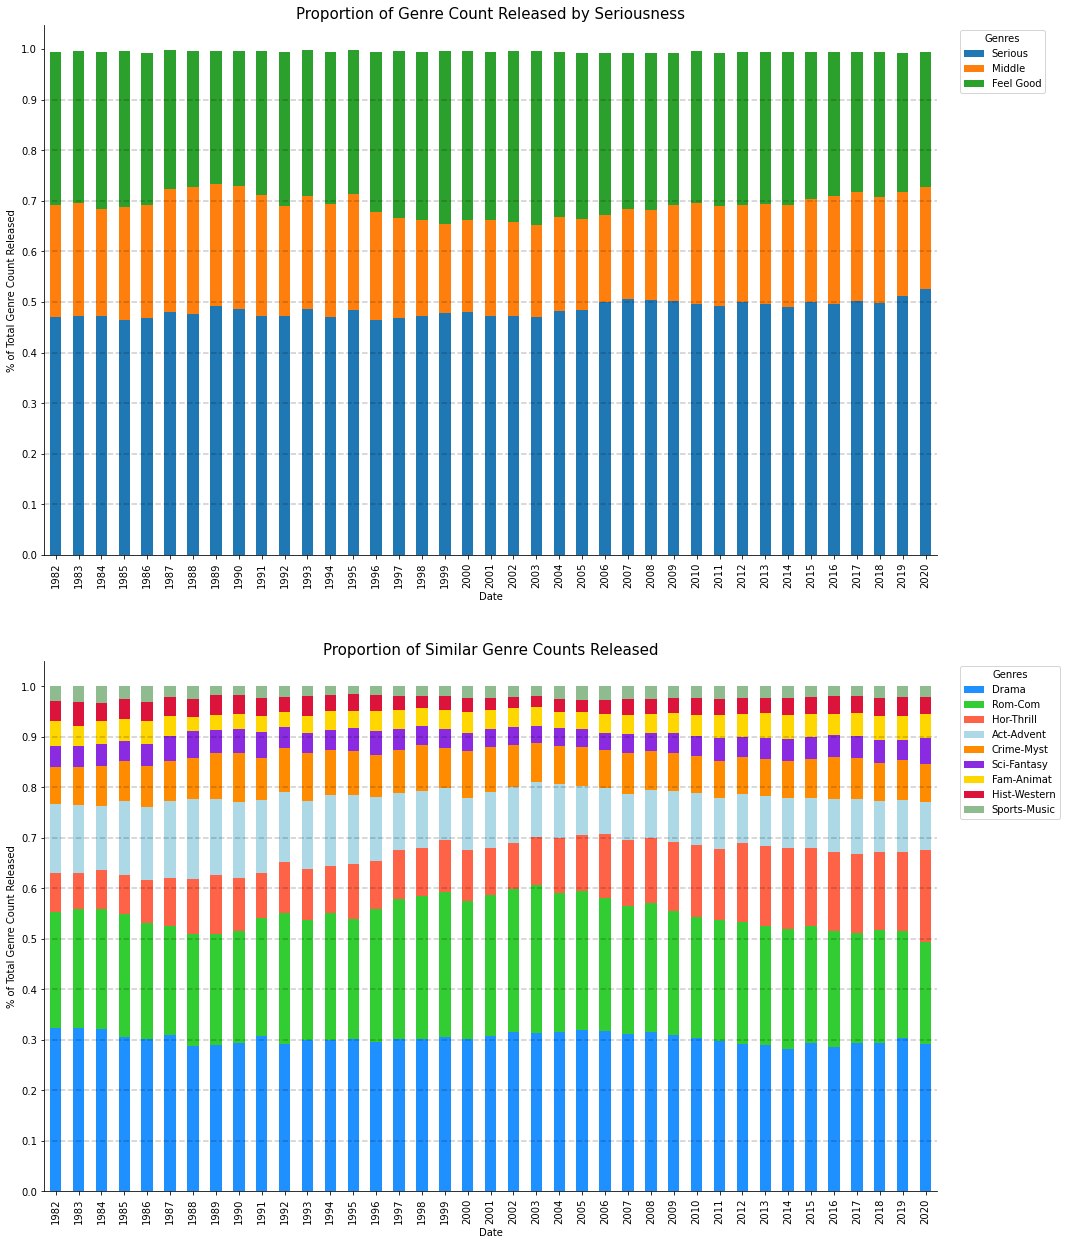

In [43]:

fig, ax = plt.subplots(2,1, figsize=(16,20))

genres_share[comb_cats].plot.bar(stacked=True, ax=ax[1], color = comb_cats_c)
ax[1].legend(title='Genres', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1)
ax[1].set_title("Proportion of Similar Genre Counts Released", fontsize=15)
ax[1].set_ylabel("% of Total Movies")
ax[1].set_xlabel("Date")

genres_share[three_cats].plot.bar(stacked=True, ax=ax[0], color=three_cats_c)
ax[0].legend(title='Genres', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1)
ax[0].set_title("Proportion of Genre Count Released by Seriousness", fontsize=15)
ax[0].set_ylabel("% of Total Movies")
ax[0].set_xlabel("Date")

for i in range(0,2):
    ax[i].set_ylabel("% of Total Genre Count Released")
    ax[i].set_xlabel("Date")
    ax[i].set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)

for i in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    ax[1].axhline(i, color="k", alpha=0.2, linestyle="--")
    ax[0].axhline(i, color="k", alpha=0.2, linestyle="--")


plt.subplots_adjust(left=None, bottom=None, right=None, top=.935, wspace=None, hspace=None)

Proportion Stack Charts

Super-Categories:
1. All the categories stay relatively consitent over time with Serious movies making up around 47-50% of all genres produced, Feel Good ~ 30%, and Middle ~20%. There are also no singular standout or outlier years for any category. 
2. Feel Good does increase in proportion by roughly 3-5% during the late 1990s to mid 2000's. It then decreases back to normal levels. As this is a long term trend that starts beore the 9/11 Recession and ends in 2007 prior to the Great Recession, it is probably the result of a change in culutre outside of the economy. 
3. There is also very little change after the Great recession meaning the recession did not have a major impact. 

Similar Genres:
1. Again, the genres proportions as a share of total genres produced stay relatively constant by usually only moving 1-2 percent year to year. The long term exception is Horror-thriller which goes from ~5% in 1982 to nearly ~18% in 2020. It seems to be pulling shares from Romance-Comedies and Action-Aventure films which both slighly decline in their proportions over that period. 
2. Once again there are no singular standaout of outlier years for any genres indicaiting that Hollywood has a pretty established fomula on what to produce.



# Section 3: Interpritations and Conclusions

# Interpriation Outline
1. Economic indiactors have little effects on demand

2. Ecnomic indicators might have some impact on supply, prior to recessions (maybe)

3. Recessions might have some imnpact on genres but its likely other reasons causing the changes. So genres produced largely independnt of economy.

### Recall Questions
1.   To what extent can the state of the economy explain supply of and demand for cinema entertainment?

2.   Does the state of the economy influence the genre mix of the supply and the demand?

3.   Do other external influences besides the state of the economy have equal or maybe higher explanatory power concerning supply of and demand for cinema entertainment?


### Recall Objectives
The objective of this project is threefold. First, we analyze whether there is a general impact of GDP per capita, consumer sentiment, and unemployment rate on the movie industry. By analyzing the number of movies released (supply) as well as the box office revenue (demand), we can distinguish between the reaction of the industry and that of the audience. 


In the second step, we capture possible shifts in the market shares of different genres by analyzing genre-specific supply and demand. Judging from the literature, we expect limited and delayed effects of changes in economic indicators on supply and demand for cinema entertainment. The time lag is likely to differ for the variables. Consumer confidence and demand may change synchronously while it would take some time for distributors to adjust supply to a changed GDP. 


In the third step, In the third step, we analyze whether there is actually a reciprocal relation between supply and demand and introduce historic event as alternative explanation.

### 3.1 Demand

### Demand Interpretation (to be cleaned)
1-We found hat there were co-movement between the economic variables and the film industry variables for some periods. However, the patterns were not strong enough to say that there was the same movement pattern of variables over time. The number of movie releases increased until 2019, where there was a sudden decrease of releases. That year, there was also a sudden decrease of revenues just before the pandemic of 2020. The film industry reached its peak of releases in 2019, whereas the peak of gross revenues were reached just after the Dotcom recession in 2001. That implies that the increase in the number of movie releases did not increase the gross revenues of the film industry significantly any further after 2001. During that time, the GFC played a very important in the economy, where there was the unemployment rate almost reaches 10%, the GDP per capita decreased from 50000 to 47000 millions of US dollars, and the consumer sentiment index decreased from 90 to 60. 

2-Hence, we can say that the demand side of the film industry could have been affected by the GFC. Then, in all the other cases, the demand side of the economy was not significantly affected by the recessions. Thus, we can say that during only one of the five recessions analyzed in our time period, there was only one recession that could have had an indirect effect in the film industry. Hence, we cannot conclude that the film industry was affected by economic variables. This view would be onsistent with the studies referred to in the literature review. 

3-On the other side of the economy, the film industry supplied movies almost exponentially following the same trend as the increase of GDP per capita over time. Therefore, we could argue that the changes in the busnes cycles were not significant enough to say that the film industry is affected by the economic variables.

4-Therefore, we could say that the film industry is affected indirectly by some factors of the economy in an indirect way. However, the converse argument is not true.




### 3.2 Supply Interpretation (some ideas)

-We find no effect of the economy on the genre mix of the supply of movies. However, There seems to be a connection between the GDP per capita and the overall supply measured in the number of films released. --> The number of films released is influenced by the number of films released in the preceding quarter (lag 1) and three quarters before (lag 3). 

-The change in GDP per capita does not affect respective revenue share of the three umbrella genres. Thus, the genre mix cannot be better explained using economic indicators and vice versa. 

-Supply is affected by economics varriables (UK). Supply affects economic variables (Germany).

-The behavior is explained by the fact that going to the cinema is a cheap  leisure activity. This behaviour didn’t change until very recently when other factors came into play such as Netflix, etc.

-Film is regarded as art.

-No correlation between quality of the supply of movies and the demand of movies.

-The economic and quality indicators cannot sufficiently explain the shifts in genre structure of movie supply and demand.

-If the economic and quality indicators cannot sufficiently explain the shifts in the genre structure of movie supply and demand, and demand only partly instructs supply, other influencing factors might be more powerful explicators. We follow the approach of Gowgiel and Mcintosh (2010) who suggest that different types of threats might have different effects on TV viewing habits. They use the attacks on the World Trade Center as an example of a physical threat and the collapse of the Lehman Brothers bank as example of an economic threat. While the former would lead to a higher demand for serious content, the latter would have no effect on viewing habits. Overall demand in our sample is fluctuating too much to render an impact-response-analysis a viable analytic strategy. Thus, in the following we will provide a visual inspection of the data and focus on changes in the genre shares in the aftermath of the same events analyzed by Gowgiel and Mcintosh. 

-We can conclude that on the supply side, the distributors show a more pronounced reaction on external event than the audience on the demand side. This supports the view of distributors not only reacting on the demand but reacting based on a sense oof a mission.

### 3.3 Genres Interpritation

With regards to the initial hypothesis that an economic downturn will lead to increased popularity in feel-good movies as people try to forget about their hardships, the hypothesis should be rejected. While the Gulf War Recession did seem to support this hypothesis, that was the only recession that did support it. And even then, because of the cyclical nature of the Feel Good category, it makes it very difficult to say if Feel Good increased because of the recession or some other reason. All other recessions show either all the super categories moving together or one of the two more serious categories performing better than Feel-Good. In addition, because most of the super categories hit their highest almost perfectly in between recessions it makes it very hard to say the economy had any real impact at all. 

However, the economy does seem to have some impact on genre production when we look at the similar genres more specifically. In most cases, the less popular genres face downturns in growth during and in the first period after a recession. The most popular genres are affected to a much smaller degree. This shows that studios become more risk-averse during and after recessions. They'd rather invest in movies they know will be more popular and are likely cheaper to make. As SciFi-Fantasy movies typically require larger budgets they become more difficult to produce when finances become tight in a recession.

### Conclusion (to be cleaned)

-The demand for cinema entertainment as a whole is unrelated to economic indicators such as GDP, consumer sentiment, and unemployment rate. Only the GDP per capita has some effect on the overall demand. In the US, a cinema visit can be considered as a low-cost leisure activity. 

-We could possibly find different results for markets in which a cinema visit is more expensive relative to purchasing power. However, we find no connection between income and genre choice. We have contradictory results concerning the interaction between economy and movie supply. The results might be improved if we could add information about the average production budget to the number of films released. The number of films released is less likely to change with the GDP than the budget since the number of screens and the release slots remain on the same level while the production funds might dry up during a recession. 

-However, it is evident from our results that many distributors are not predominantly in the market for profit maximization since they constantly release more serious movies than are in demand. Distributors seem to be willing to adjust their movie portfolios to economic and societal changes, but they do not seem to be especially good at anticipating shifts in audience interest.

-Last recession showed a negative correlation between releases and GDP per capita. Given that recession, was very small, we cannot say that the decrease in movie releases was due to the recession but due to other factors in the economy such as covid and other technology improvements.

-Thus, we continue to say that the film industry is recession proof.

-The fluctuation of the quality of the movie in any given time period is higher than the fluctuation of consumer demand induced by economic growth of recession.

-The Covid recession period was different than any other recession period in the history. Histotical events since 2017 affected significantly the film industry. Then, the pandemic made the situation worse. We cannot say that Covid recession influenced dirrectly the film industry--> Film industry is recession proof.
